# EleMLDS - Exercise 4 Part I: Linear Regression
In this exercise, you will implement linear regression using the least-squares formulation as well as ridge regression for improved robustness against overfitting.

Make sure to replace all parts that say
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Happy coding!

# Q1: Implement least squares regression
In this first part of the exercise, you implement the least-squares solution to linear regression.

**Hint:** this is very similar to training a least-squares classifier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
def load_data(name):
    data = np.load(f"{name}.npz")
    return tuple(data[f] for f in data.files)

In [3]:
def plot_(data, label, params=None, basis_fun=None):
    # Plot the data points and the regression function
    plt.subplot()

    plt.scatter(data.T, label.T, c="blue", marker="x")

    if params:
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 200)[..., None]
        fx = linreg(*params, x, basis_fun)
        plt.plot(x, fx, c="orange")

    plt.show()

**a) (3 points)** Implement the `least_squares` function that computes the least-squares solution given some labelled data.
Afterwards, complete the `linreg` function; this function should apply a given linear regression model on some data.
It optionally transforms the data using a basis function, if provided.

In [31]:
def least_squares(data, label):
    # computes the parameters of a least-squares regression model
    # Input
    #  data  : NxD array of data samples
    #  label : Nx1 array of (continuous) targets
    # Output
    #  weight : the D-dim weight vector
    #  bias   : the scalar bias term

    ones = np.ones((data.shape[0], 1))
    X = np.vstack((ones.T, data.T)).T

    # Compute the weight vector using the pseudo-inverse
    weight = np.linalg.pinv(X) @ label

    # The last element is the bias
    bias = weight[0]
    
    # Remove the bias from the weight vector
    weight = weight[1:]
    
    return weight, bias


def linreg(weight, bias, data, basis_fun=None):
    # Applies a linear regression model to the given data, optionally with basis function
    # Input
    #  weight : the D-dim weight vector
    #  bias   : the scalar bias term
    #  data   : NxD array of data samples
    #  basis_fun : maps an array of samples to an array of feature vectors
    # Output
    #  predicted label: Nx1 array
    #  Be aware that the output.shape should be (N, 1) instead of (N, )!
    
    pred_lable = []
    if basis_fun is not None:
        data = basis_fun(data)
    for i in range(np.shape(data)[0]):
        pred_lable = np.append(pred_lable,np.dot(np.transpose(weight), data[i]) + bias)
        
    return np.transpose(np.asmatrix(pred_lable))

**b) (2 points)** We will need some evaluation measures to judge the performance of our models.
Implement the mean-squared error (MSE) and root mean square (RMS) functions below.

In [42]:
def mse(pred, gt):
    # Ensure pred and gt are numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Compute the MSE
    error = pred - gt
    return np.mean(np.square(error))

def rms(pred, gt):
    # run mean squared error
    mse_v = mse(pred, gt)
    
    return np.sqrt(mse_v)

Let's apply your implementation on some data!

In [23]:
dataset_name = "sine"
train_data, train_label = load_data(f"regression_{dataset_name}_train")
test_data, test_label = load_data(f"regression_{dataset_name}_test")

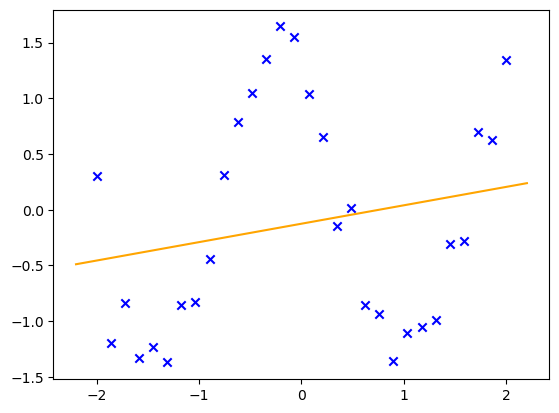

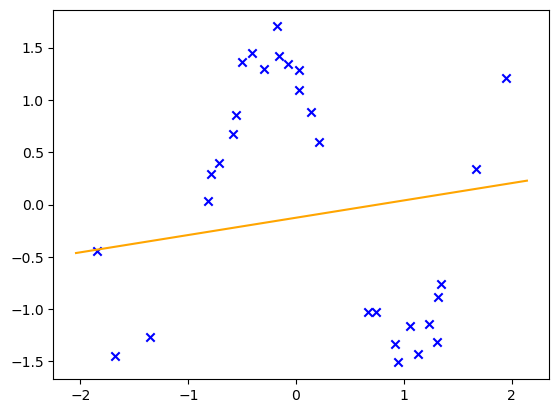

In [30]:
params = least_squares(train_data, train_label)
plot_(train_data, train_label, params)
plot_(test_data, test_label, params)

As the example shows, a purely linear model is on its own not able to model complex behavior.
However, we can again apply non-linear basis functions to the data.
Let's implement some basis function and see what effects we can observe.

**c) (3 points)** Implement a polynomial basis function below.
Since we work on 1D data here, we can use a simplified formulation:

$$
\varphi_d(x) = (1, x, x^2, \ldots, x^d)^\mathsf{T}
$$

In [57]:
def poly(x, d):
    # Input
    #  x : 1xD array of data samples (In this case D=1 since input is 1-dimensional)
    #  d : degree of the polynomial
    # Output
    #  feature : Nxd array of transformed features

    # Ensure x is a numpy array
    x = np.array(x)

    # The output feature array
    features = []

    # Iterate over degrees from 0 to d inclusive
    for degree in range(d + 1):
        # Add the feature x^degree to the feature array
        features.append(x ** degree)

    # Stack the features horizontally to form the feature matrix
    return np.column_stack(features)

We will now test how well they perform, and see which hyperparameter (i.e. the degree of the polynomial/the maximum frequency of the sinusoid) performs the best.
We also plot the norm of the parameters.

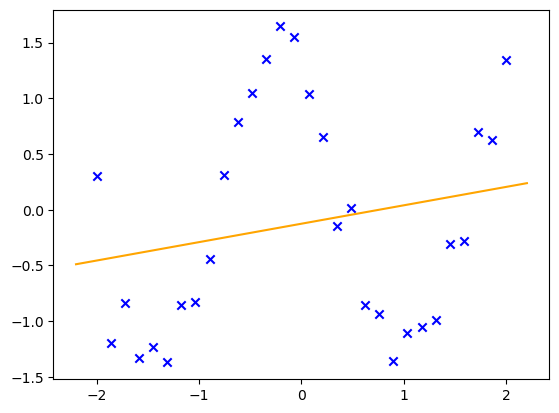

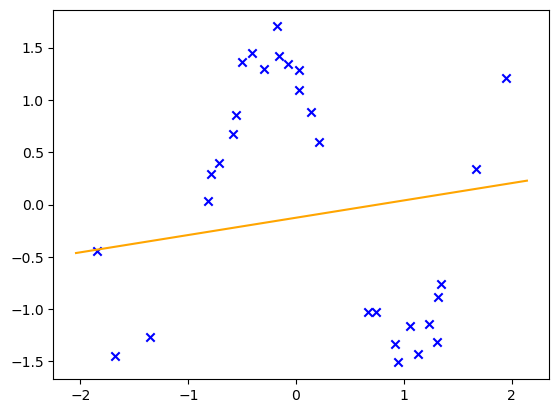

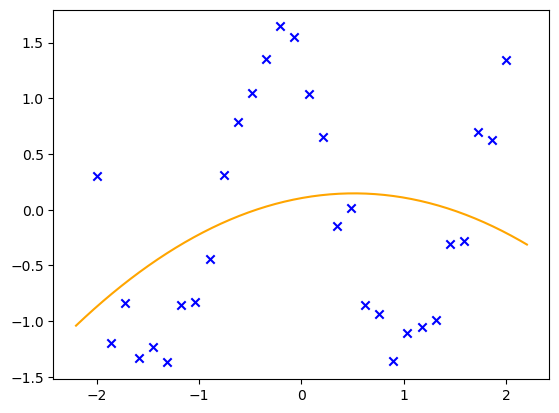

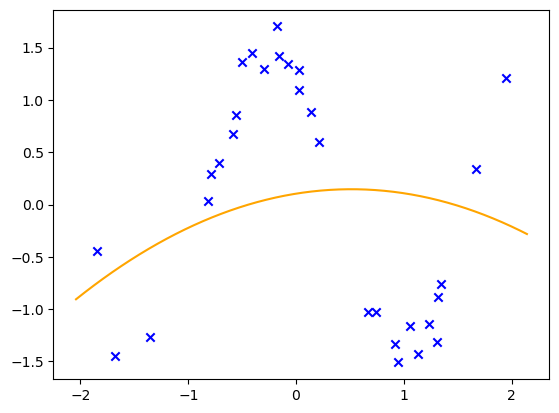

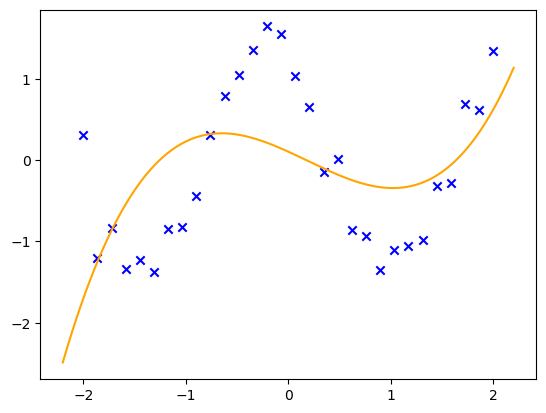

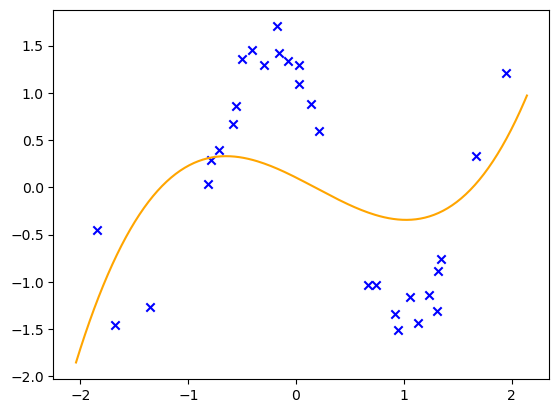

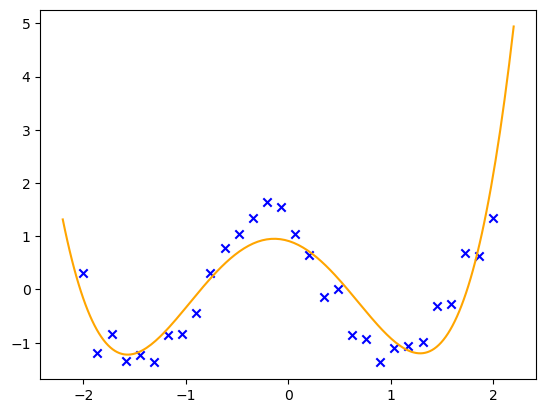

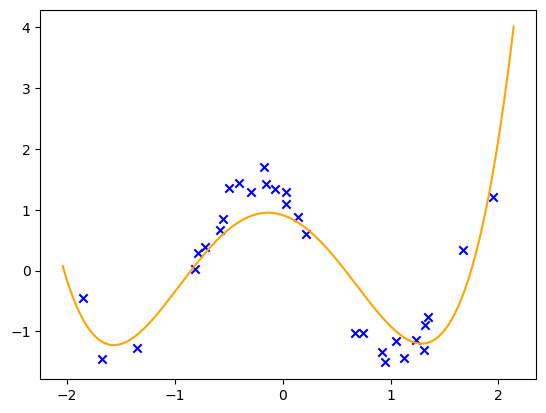

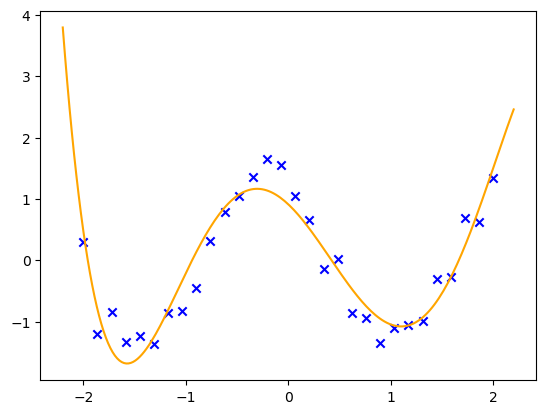

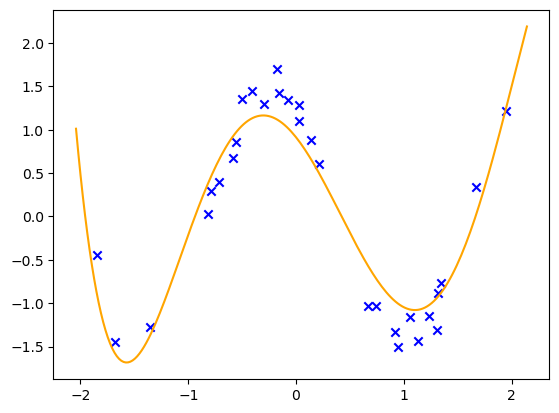

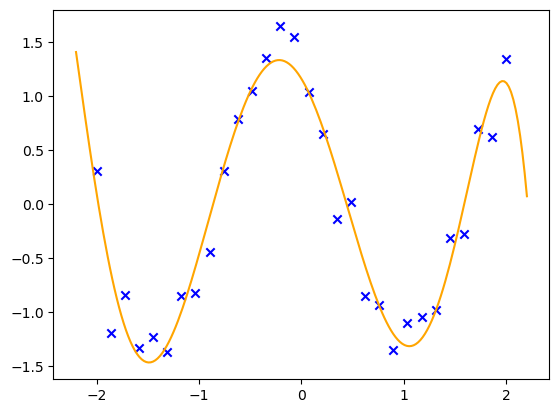

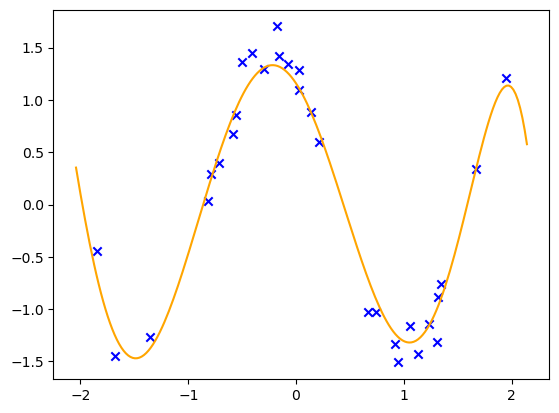

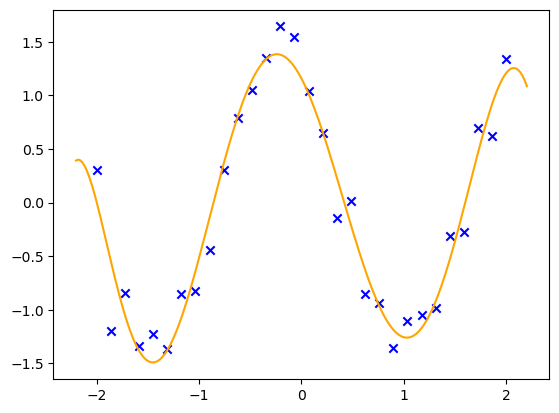

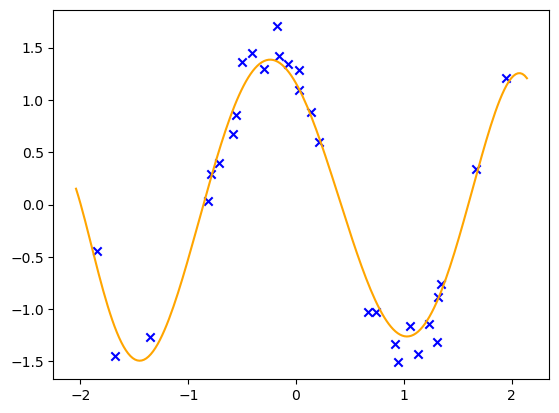

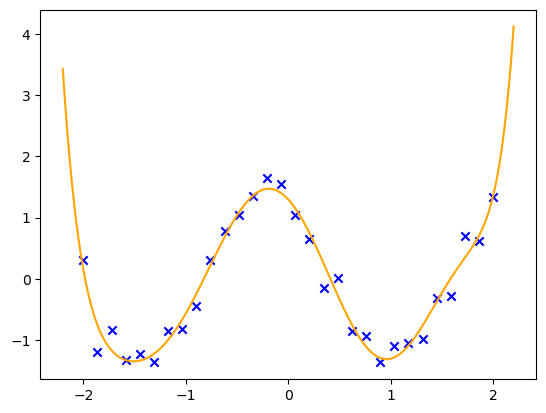

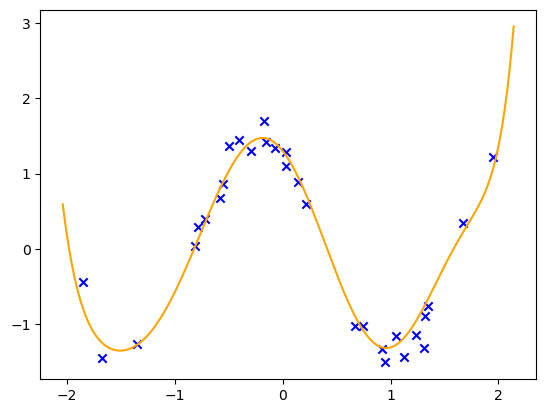

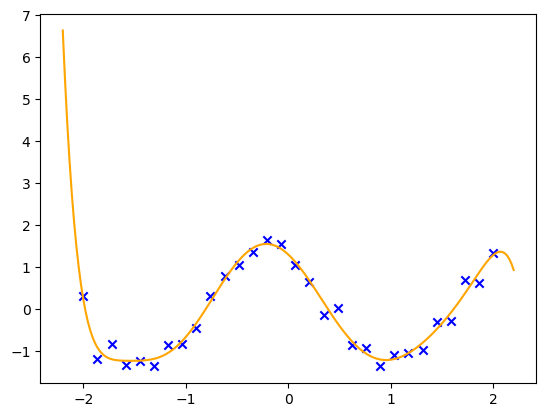

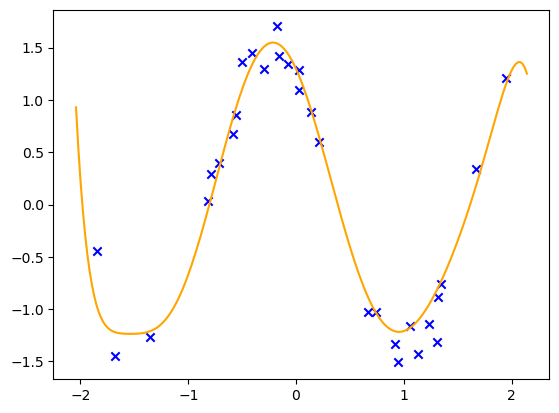

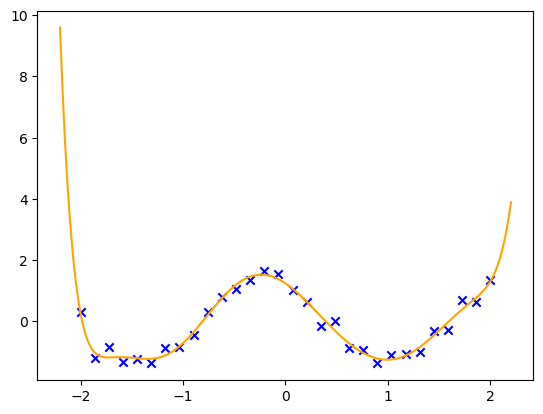

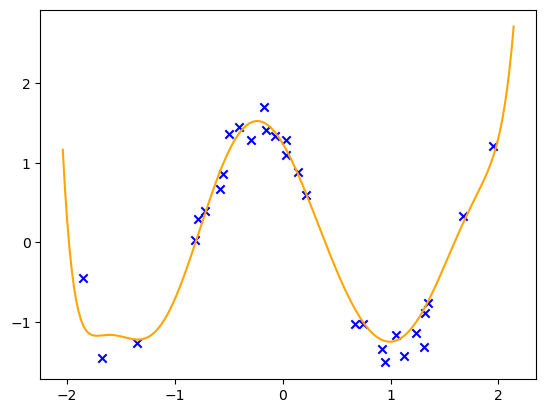

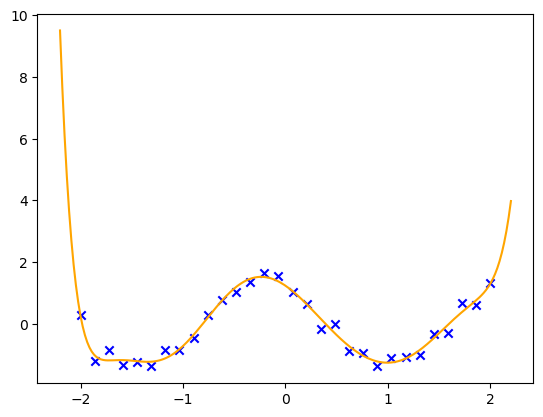

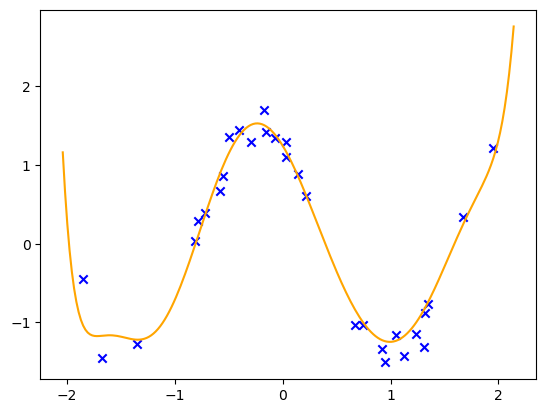

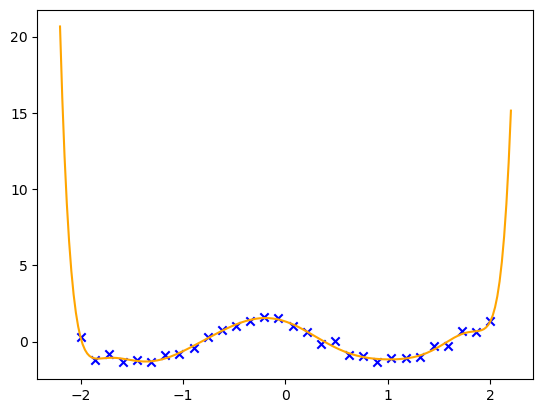

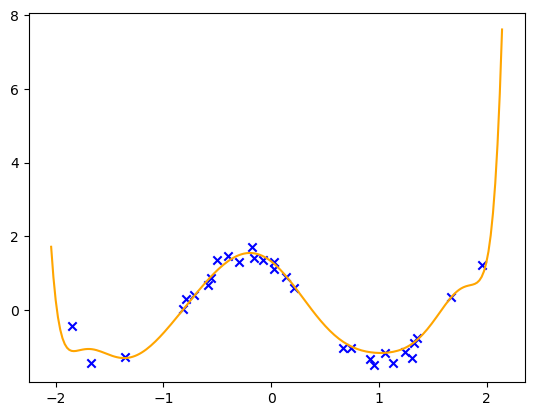

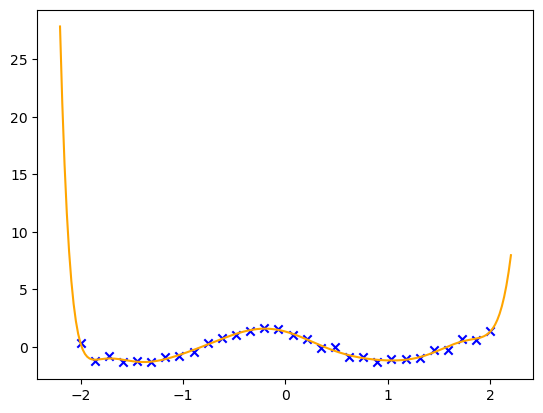

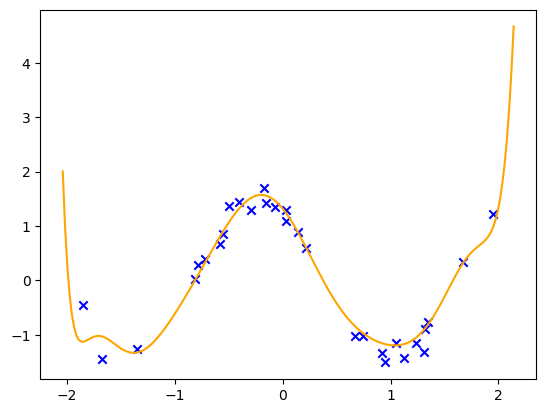

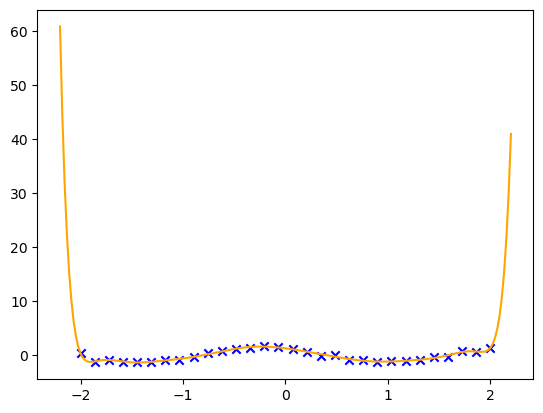

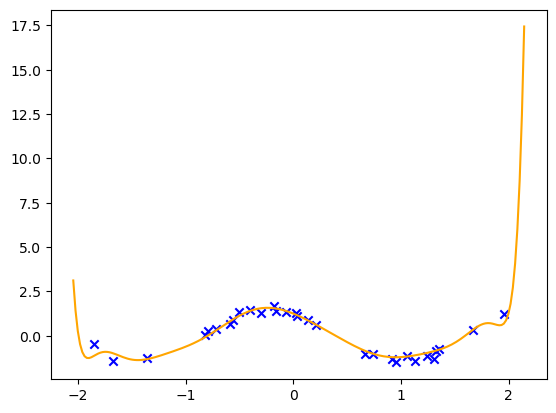

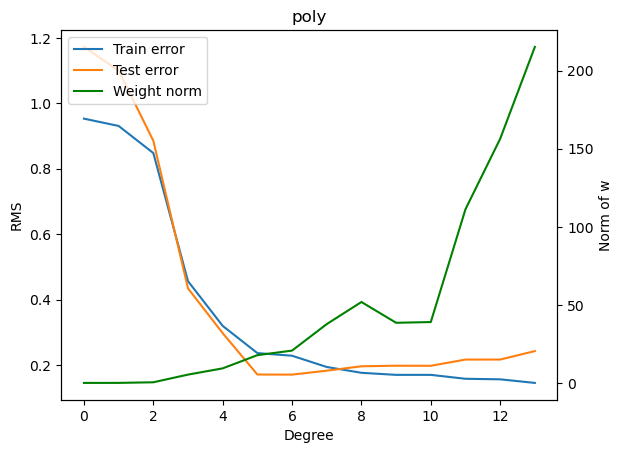

Best test error: 0.1704290549664968


In [58]:
def evaluate_basis_function(solver, fun, max_degree):
    error_train, error_test, weight_norm = [], [], []
    for d in range(1, max_degree):
        phi = partial(fun, d=d)
        params = solver(phi(train_data), train_label)

        # uncomment to visualize the regression results for all degrees
        plot_(train_data, train_label, params, phi)
        plot_(test_data, test_label, params, phi)

        train_pred = linreg(*params, train_data, phi)
        test_pred = linreg(*params, test_data, phi)

        error_train.append(rms(train_pred, train_label))
        error_test.append(rms(test_pred, test_label))
        weight_norm.append((params[0] ** 2).sum() + params[1] ** 2)
    plt.title(fun.__name__)
    ln1 = plt.plot(error_train, label="Train error")
    ln2 = plt.plot(error_test, label="Test error")
    plt.xlabel("Degree"), plt.ylabel("RMS")
    ax2 = plt.twinx()
    plt.ylabel("Norm of w")
    ln3 = plt.plot(weight_norm, label="weight norm", c="green")
    plt.legend(ln1 + ln2 + ln3, ["Train error", "Test error", "Weight norm"])
    plt.show()

    print(f"Best test error: {min(error_test)}")


evaluate_basis_function(least_squares, poly, 15)

# Q2: Implement regularized least-squares
While the results from fitting a regression function with higher-order polynomials look promising, we observed severe overfitting due to the small size of the training set and the large capacity of the model.
We will now implement regularization in order to avoid this behavior.

**a) (2 points)** Complete the function below to compute the ridge regression solution (i.e. least-squares solution with squared penalty on the norm of the weight vector).
Keep in mind that we do not want to penalize the bias term.

In [66]:
def regularized_least_squares(data, label, lam):
    # Input
    #  data  : NxD array of data samples
    #  label : Nx1 array of (continuous) targets
    #  lam   : lambda, the ridge parameter/regularization coefficient
    # Output
    #  weight : the D-dim weight vector
    #  bias   : the scalar bias term
    
    ones = np.ones((data.shape[0], 1))
    X = np.hstack((data, ones))

    # Regularized least squares
    # Add lamI to the normal equation
    identity = np.eye(data.shape[1] + 1)
    identity[0, 0] = 0  # No regularization for the bias term

    weight = np.linalg.pinv(X.T @ X + lam * identity) @ X.T @ label

    # The last element is the bias
    bias = weight[-1]
    weight = weight[:-1]

    return weight, bias

Let's repeat the experiment from above with the regularized least-squares solver.
What do you observe now?

##### lambda = 0.001 #####


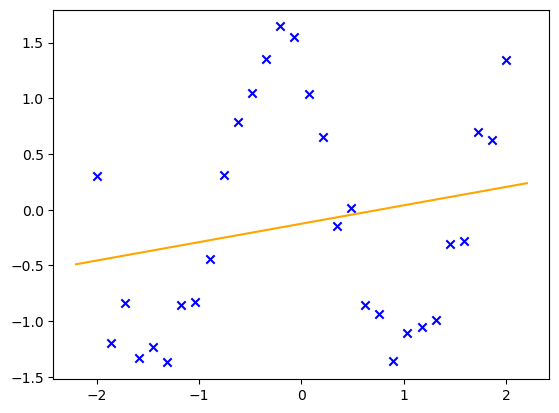

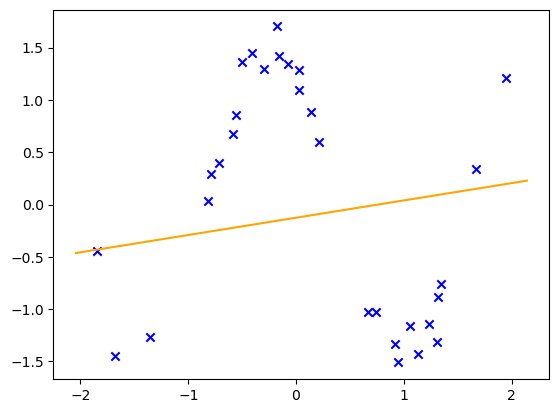

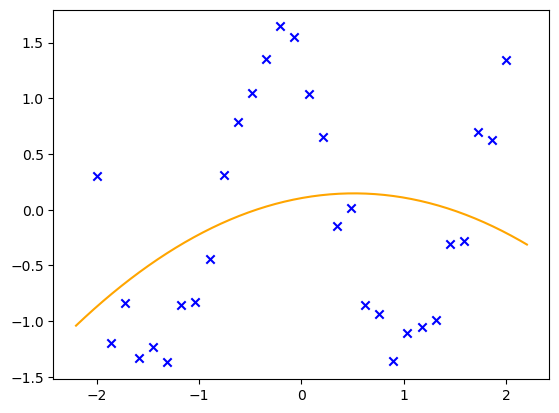

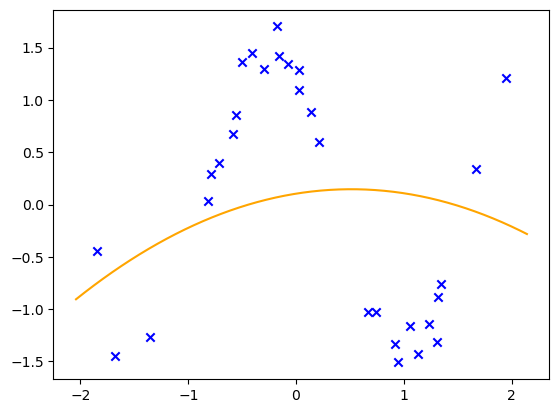

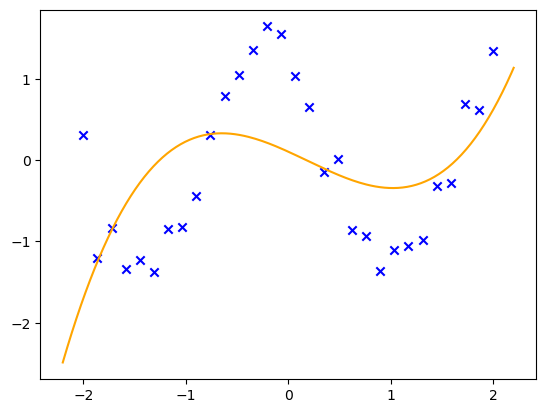

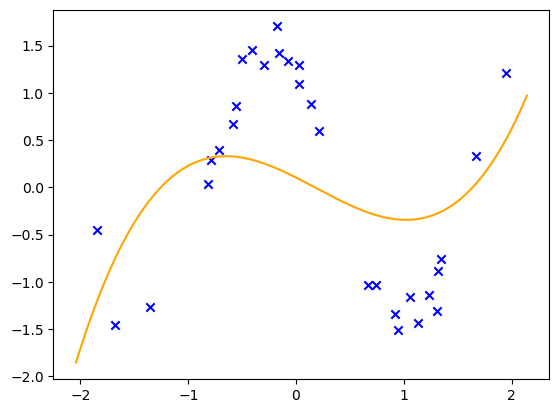

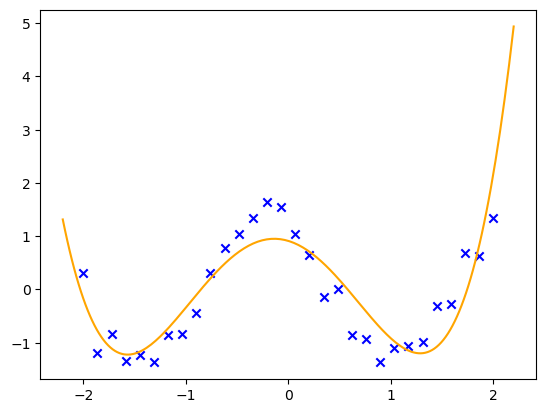

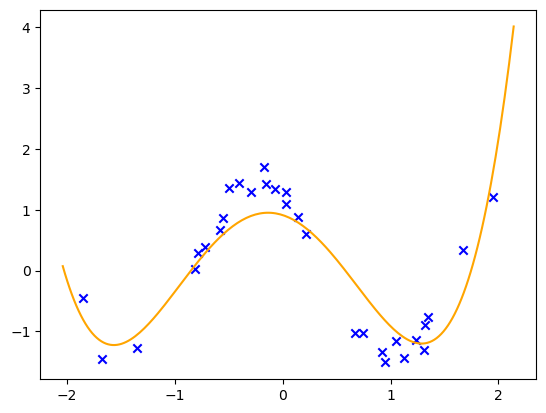

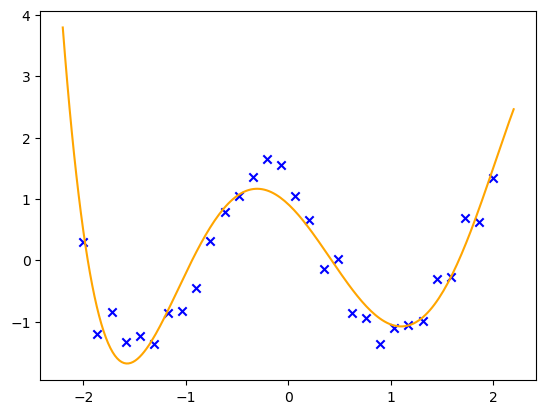

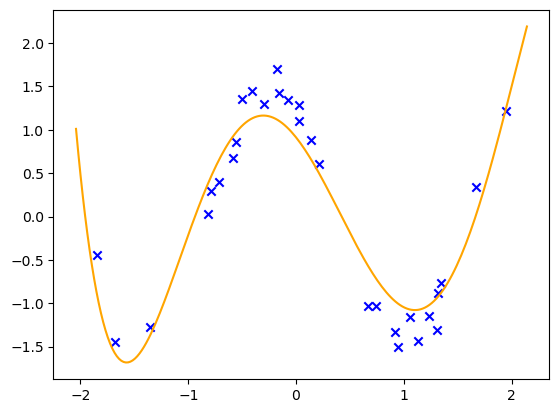

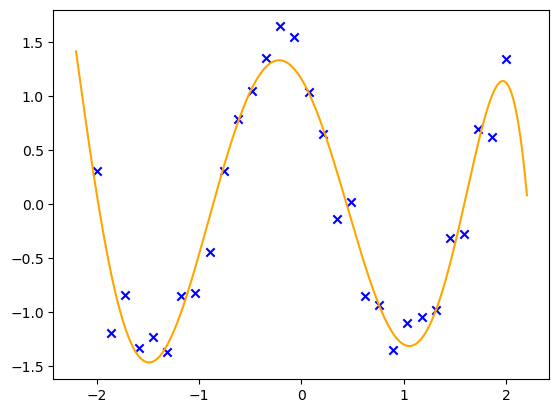

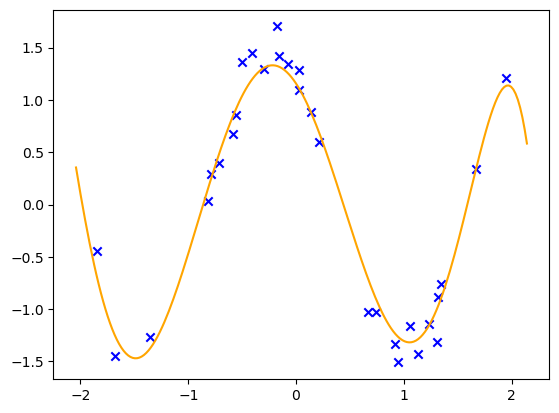

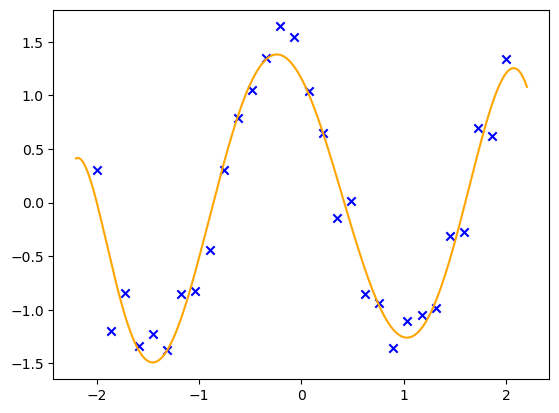

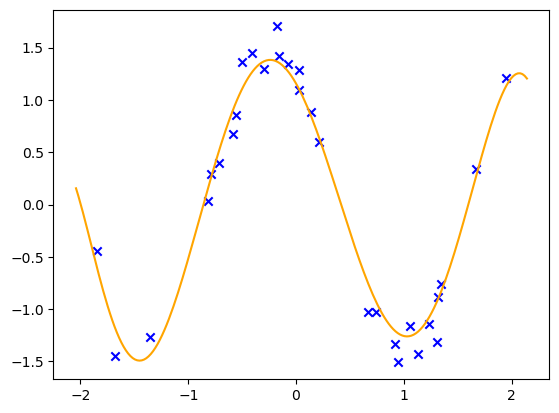

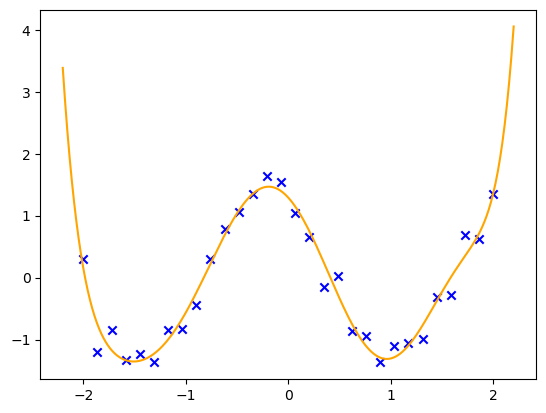

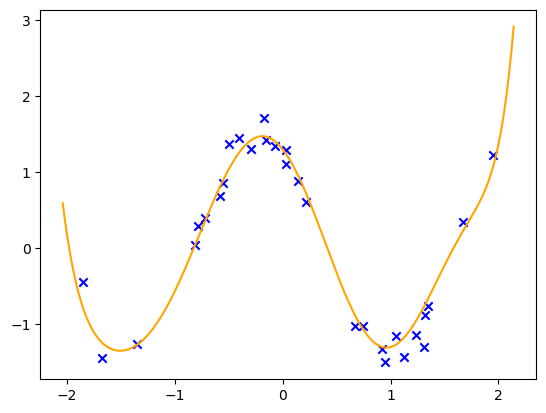

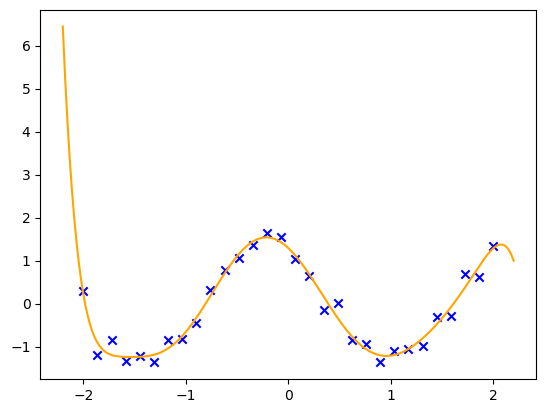

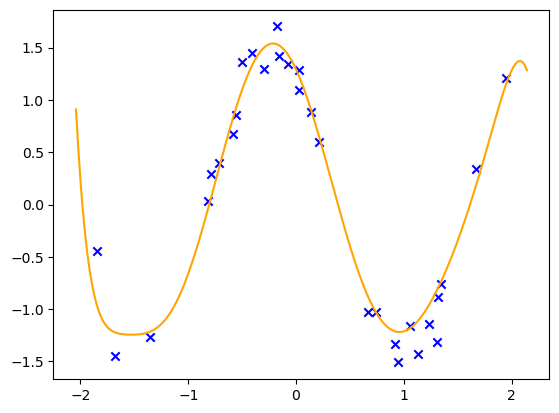

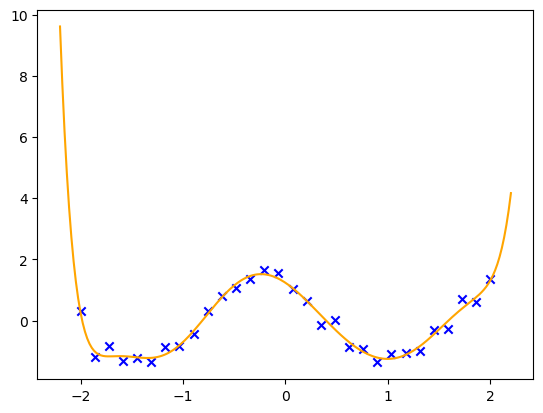

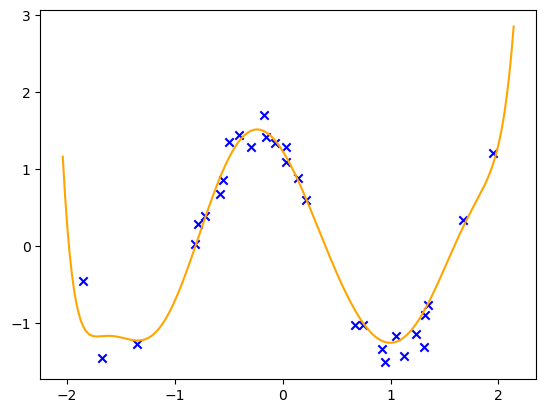

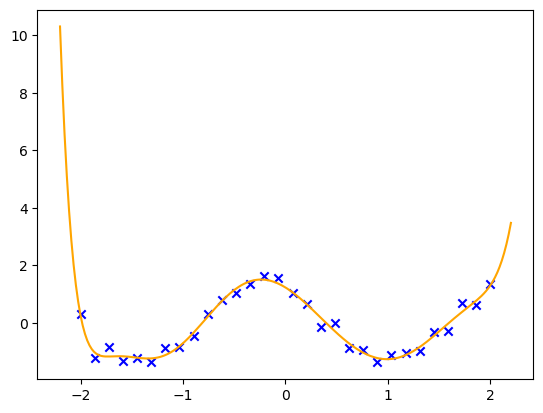

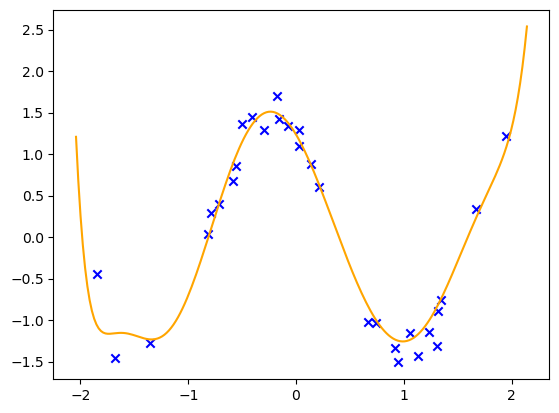

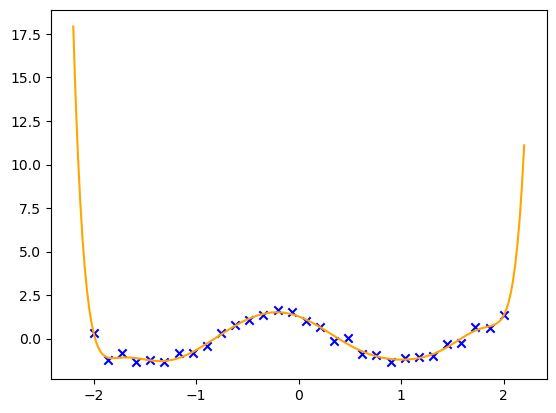

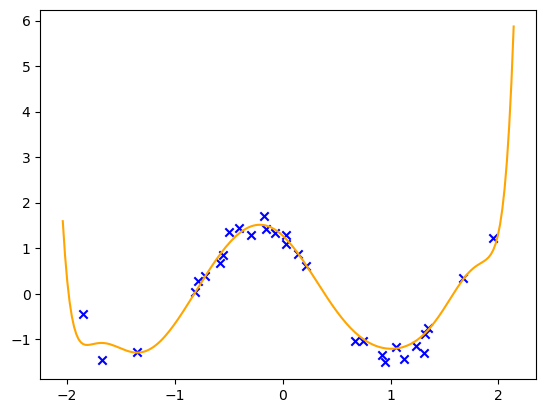

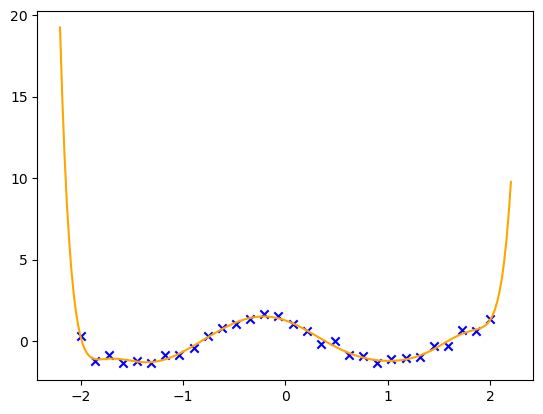

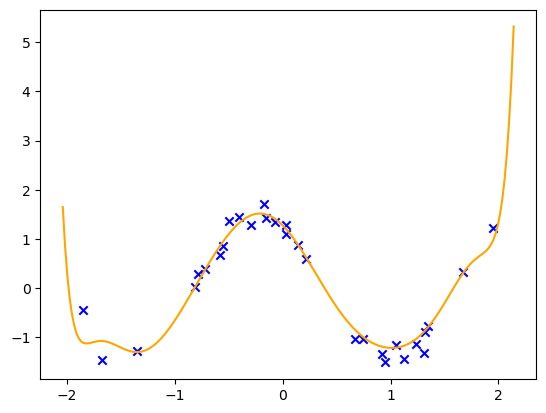

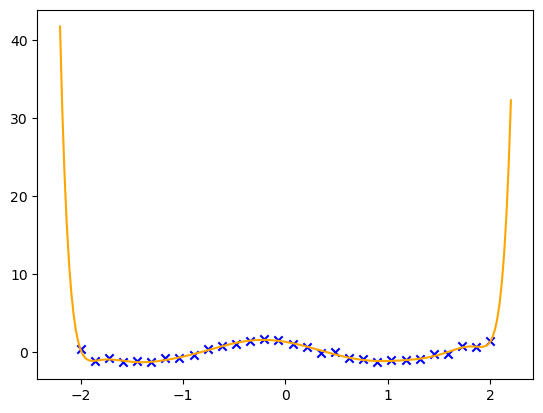

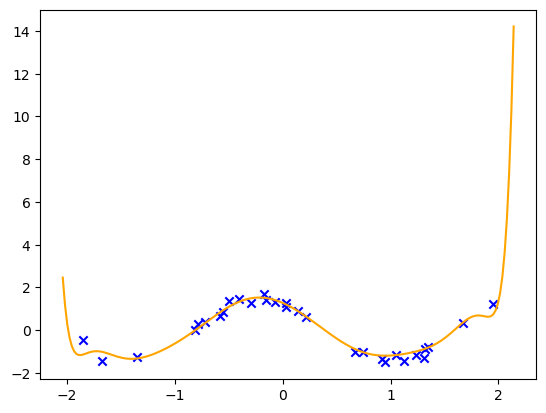

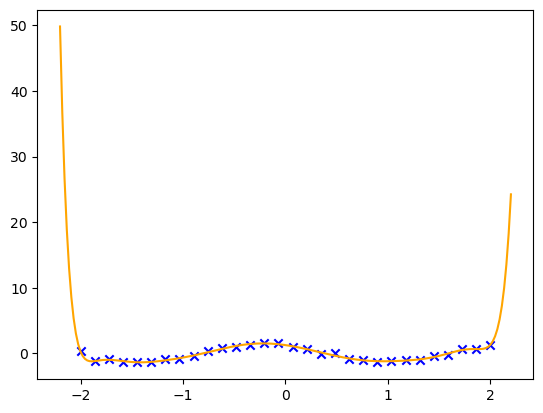

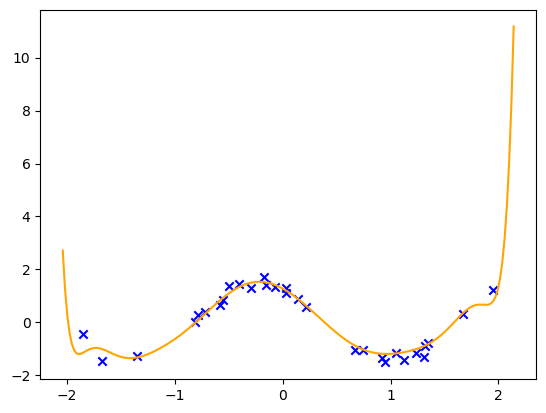

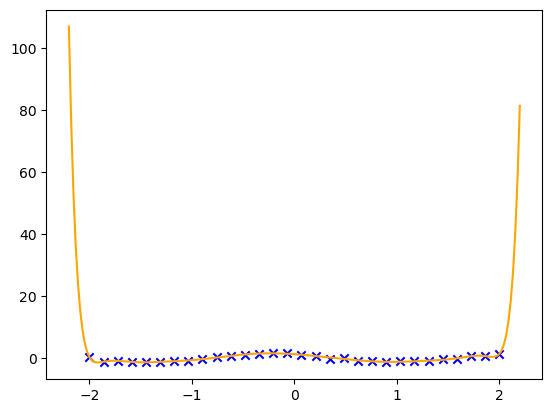

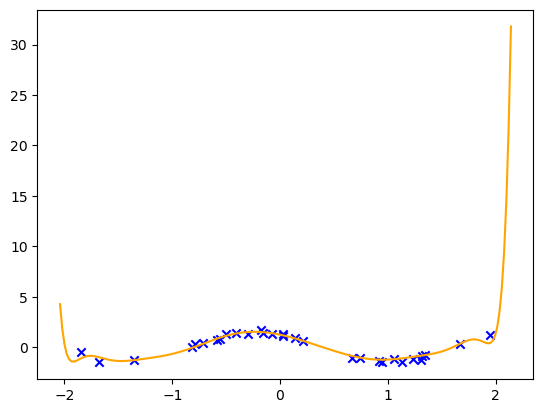

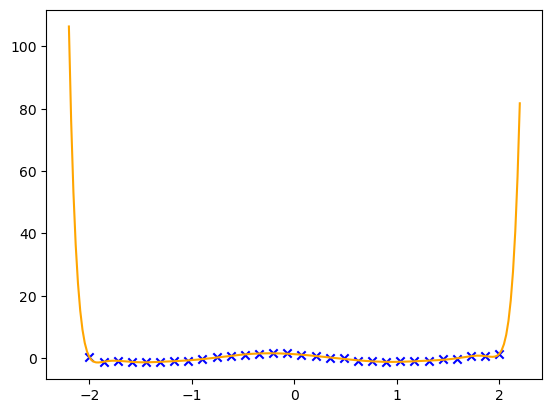

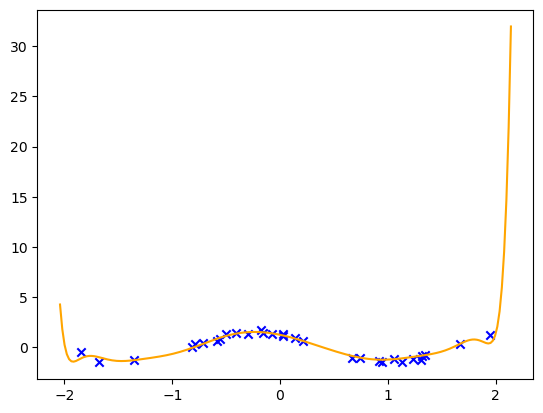

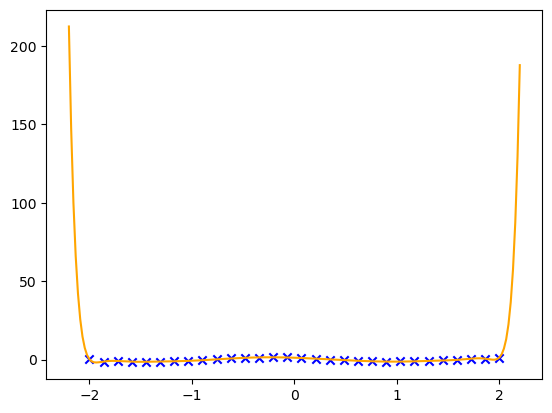

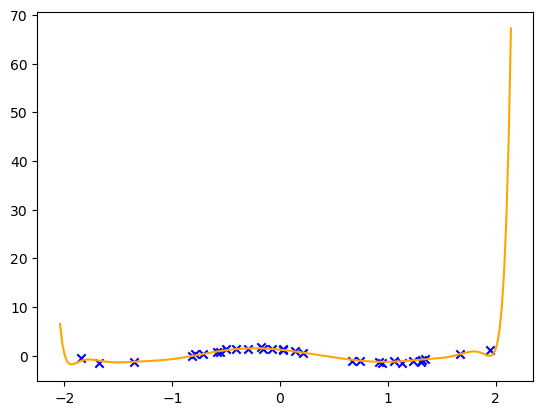

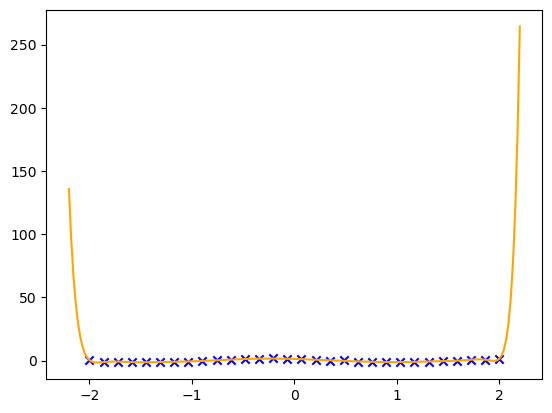

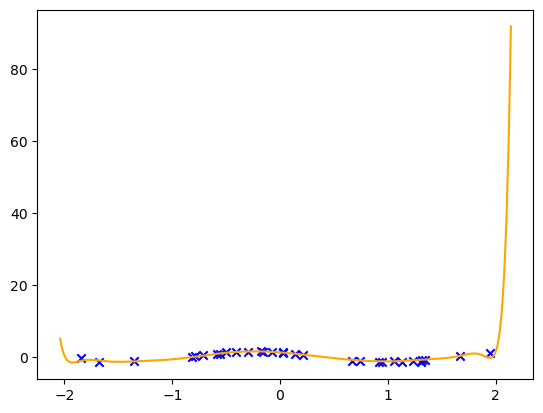

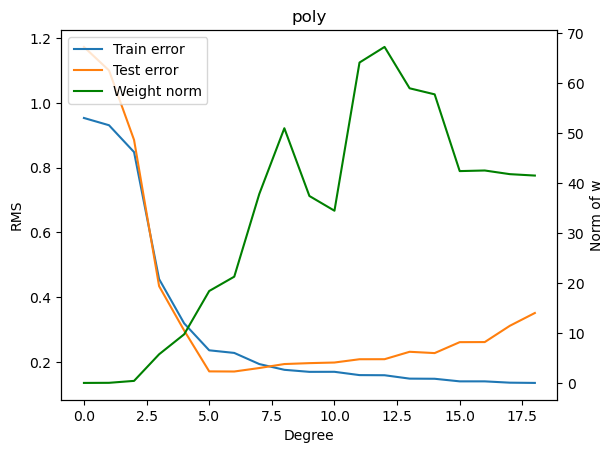

Best test error: 0.17079571032256913
##### lambda = 0.01 #####


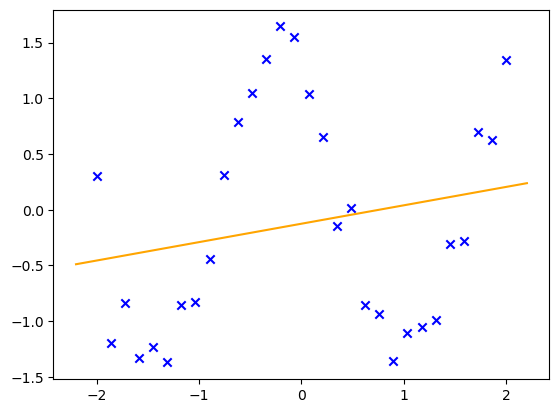

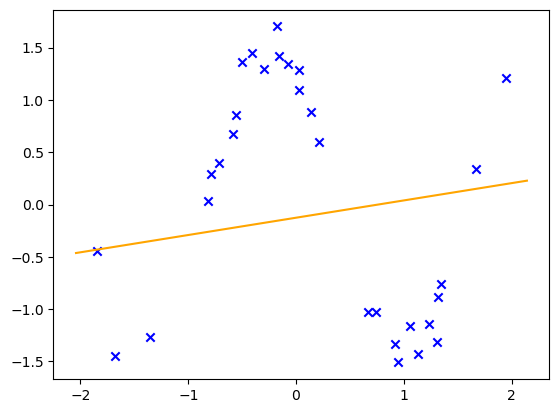

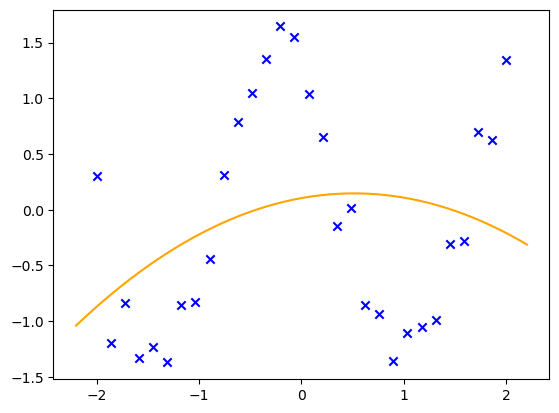

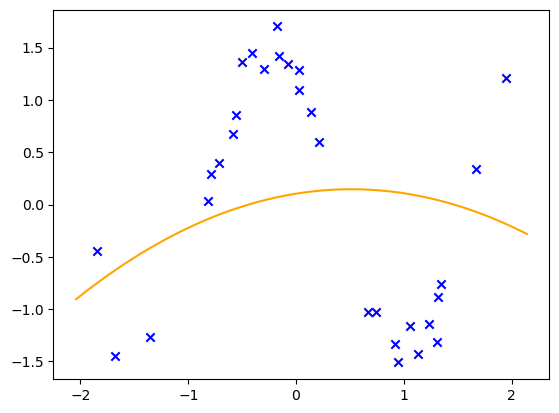

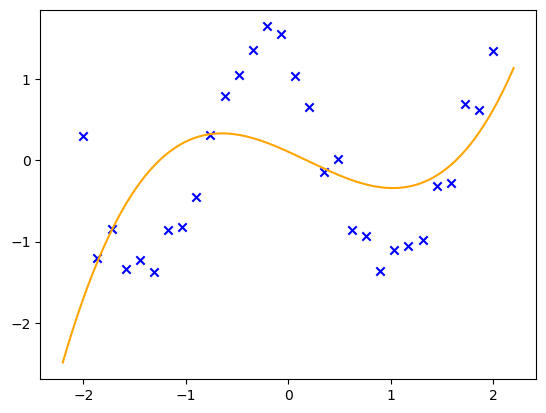

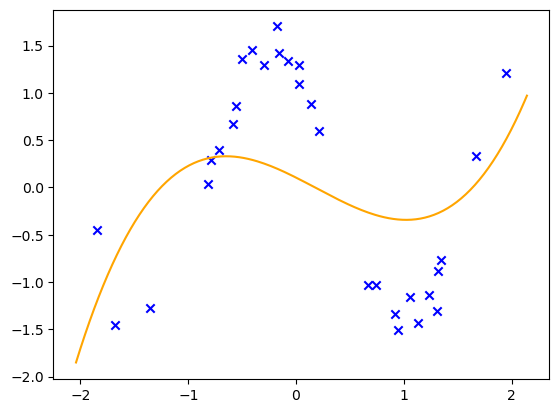

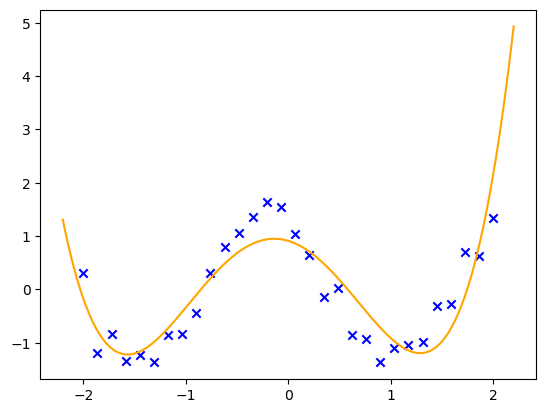

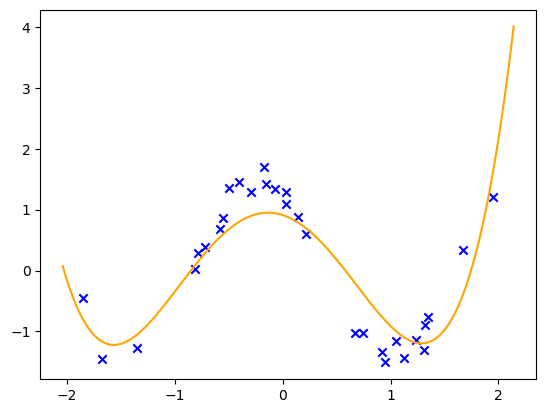

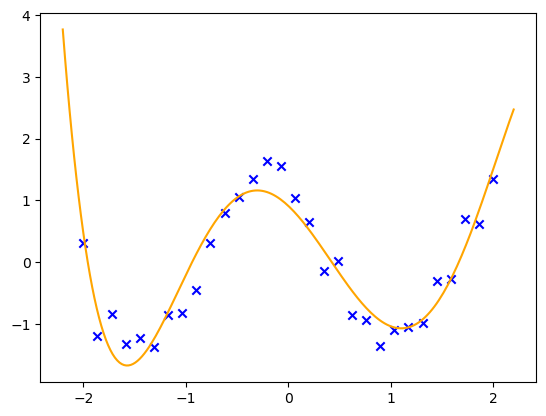

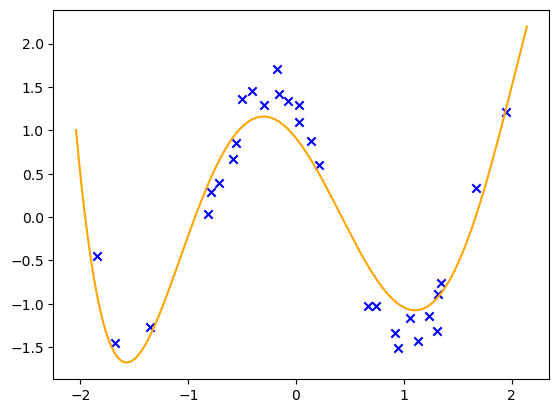

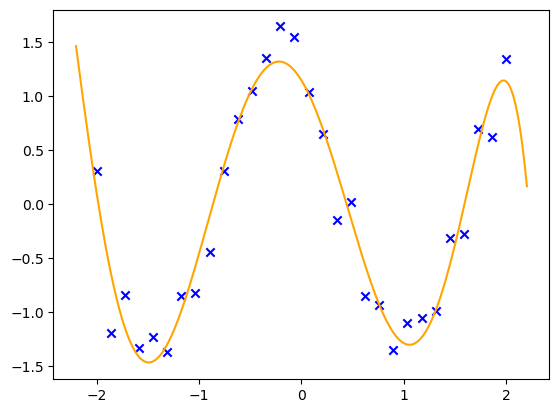

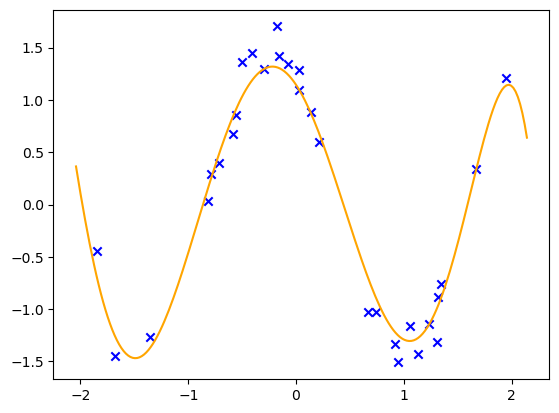

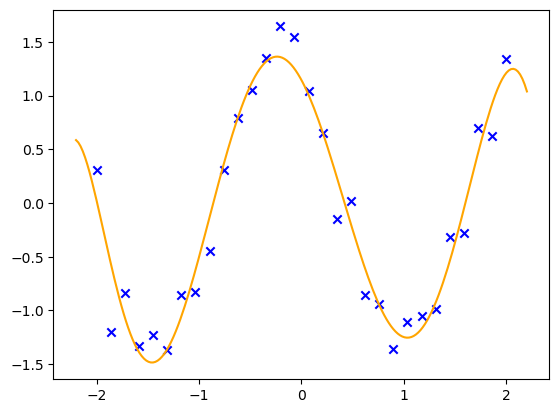

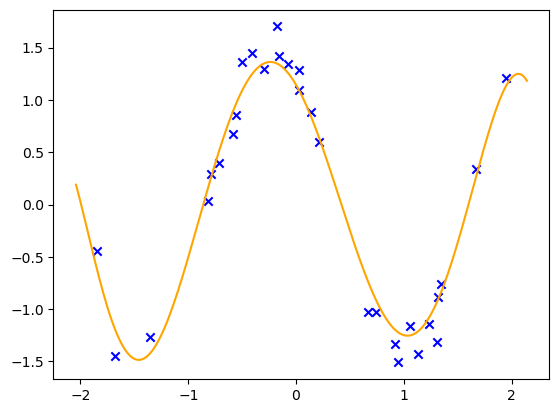

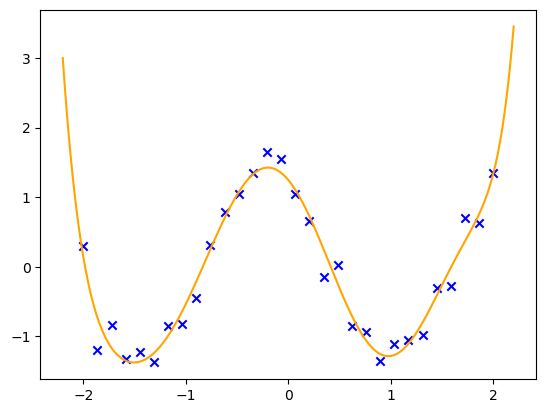

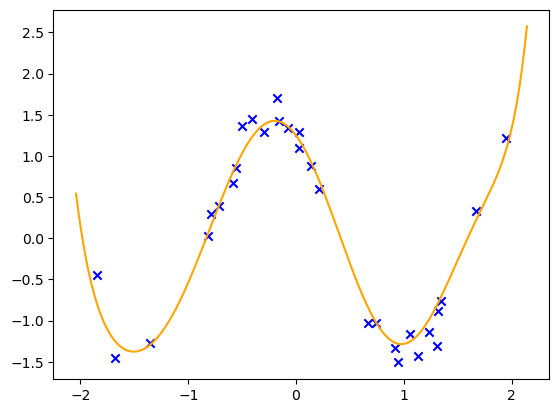

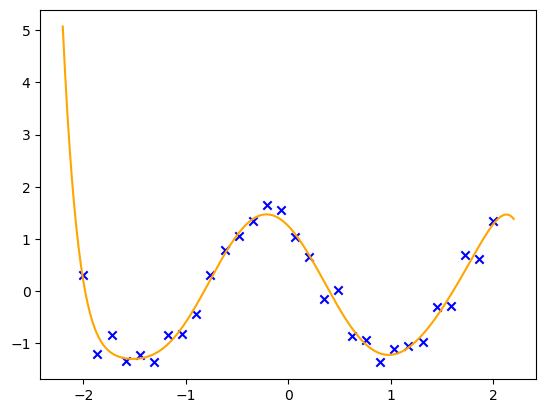

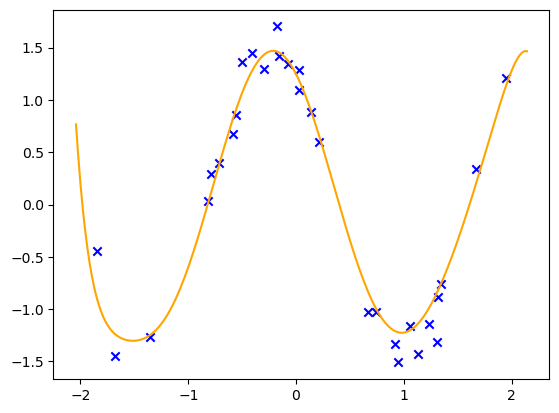

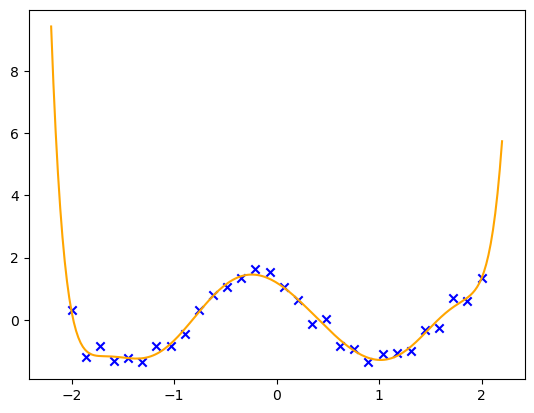

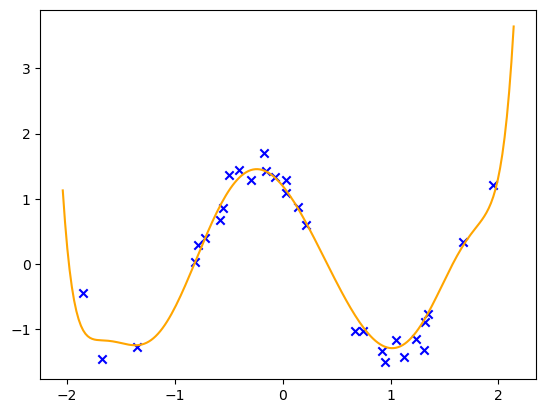

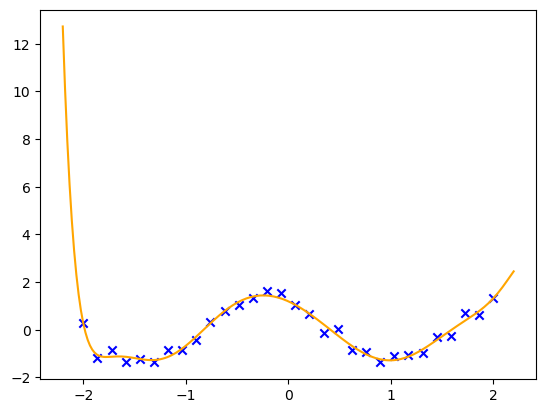

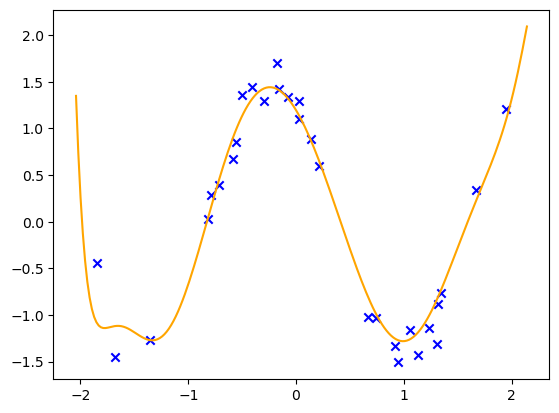

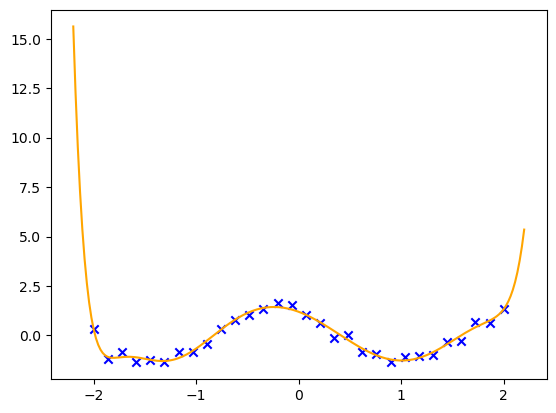

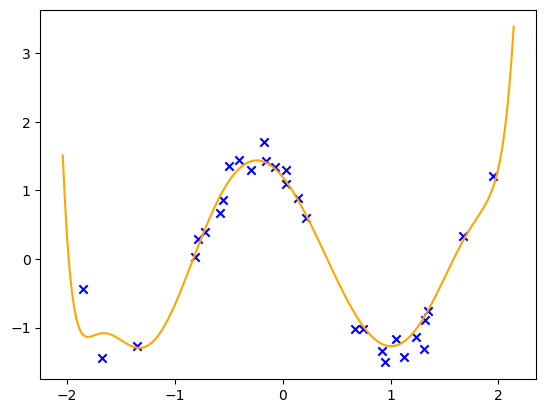

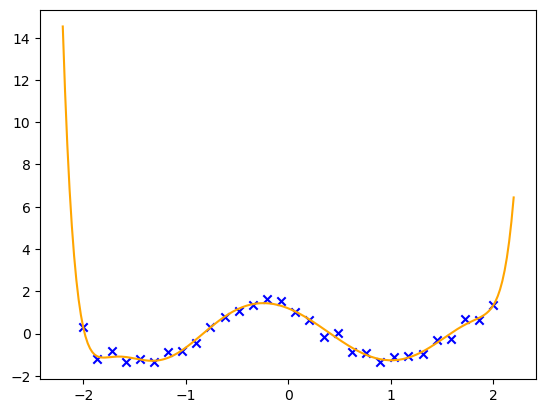

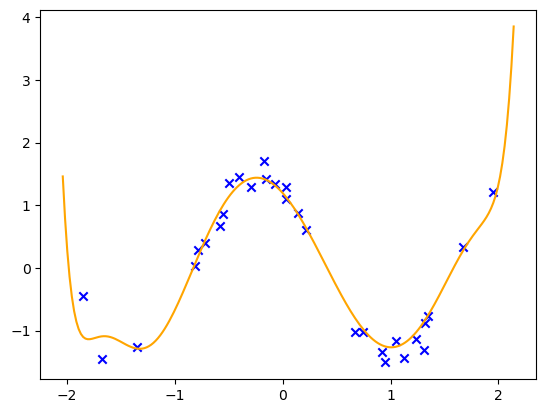

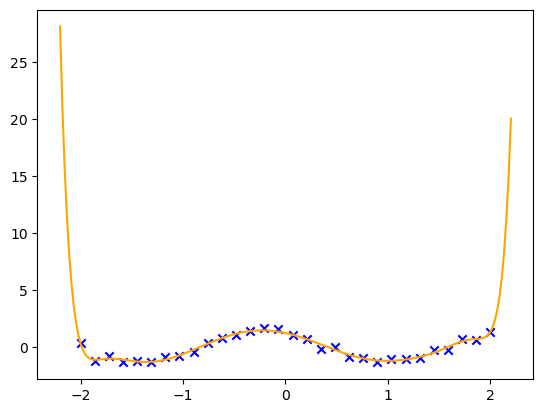

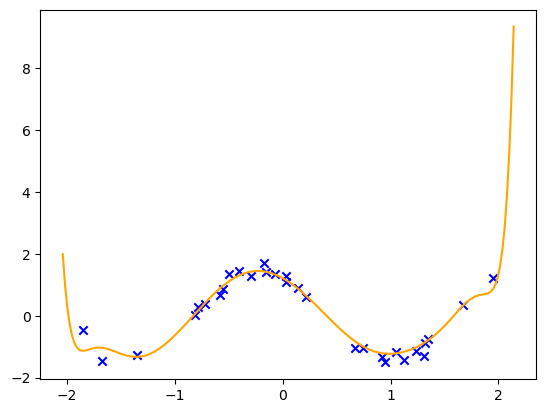

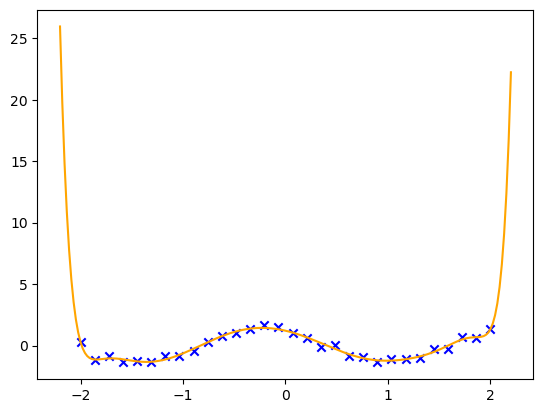

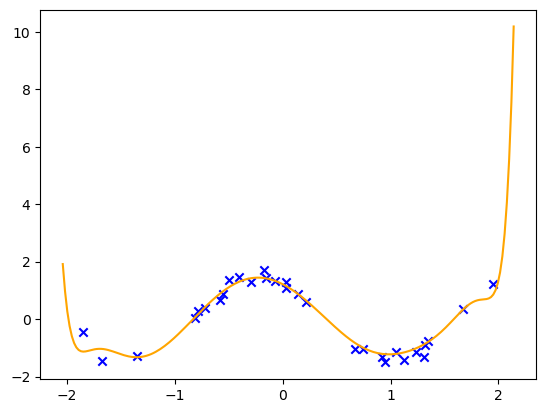

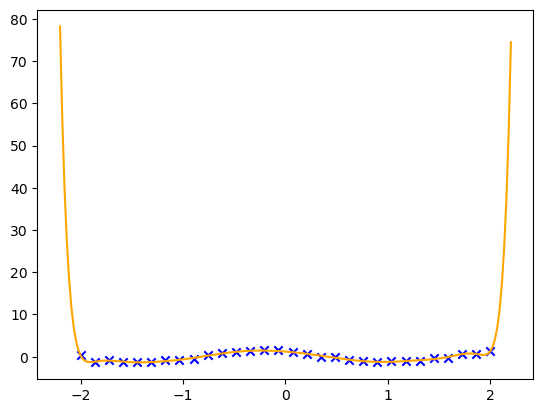

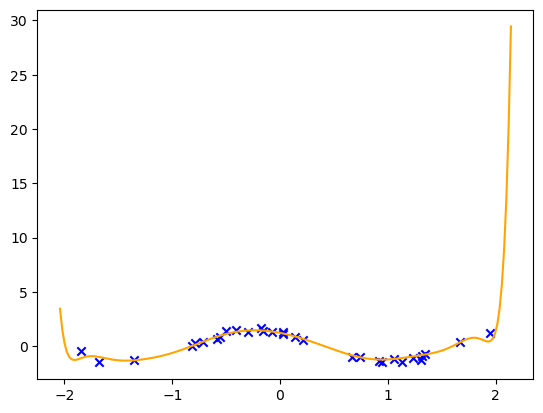

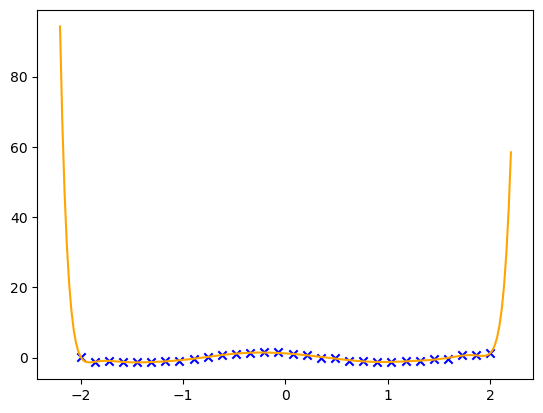

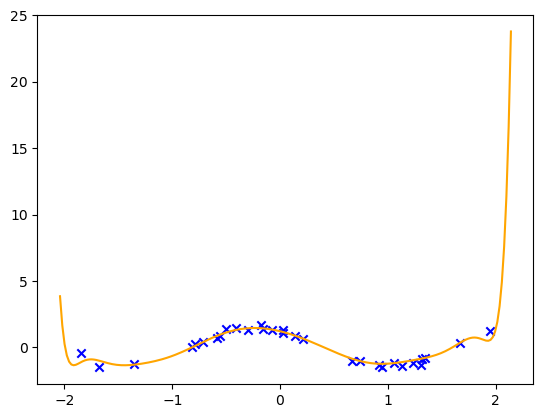

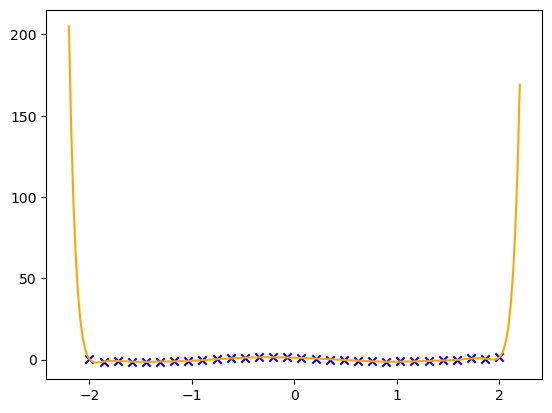

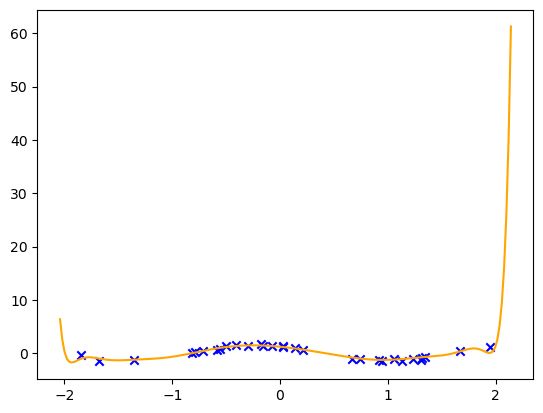

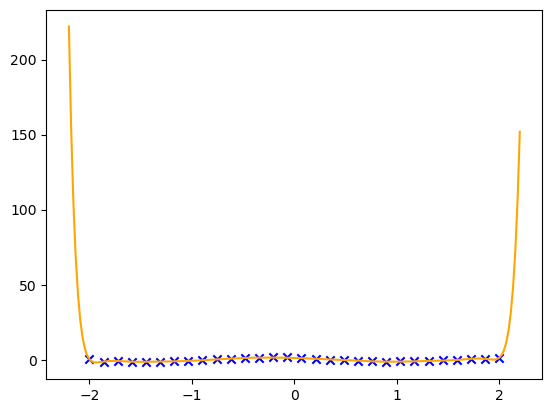

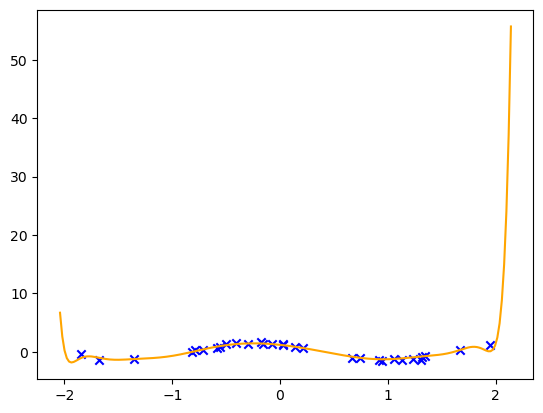

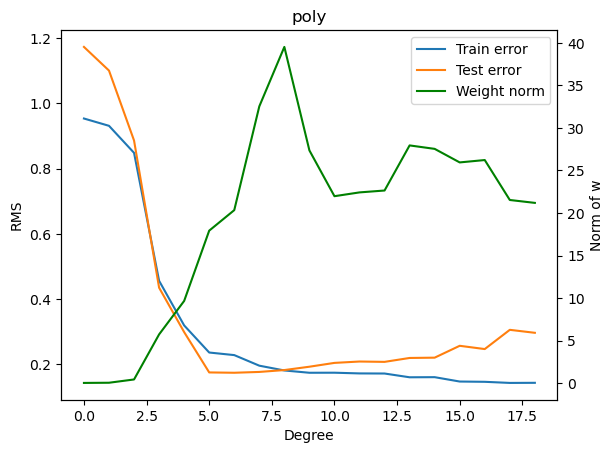

Best test error: 0.17444550910362744
##### lambda = 0.1 #####


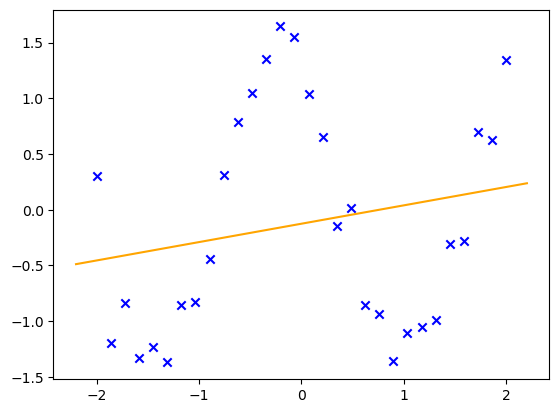

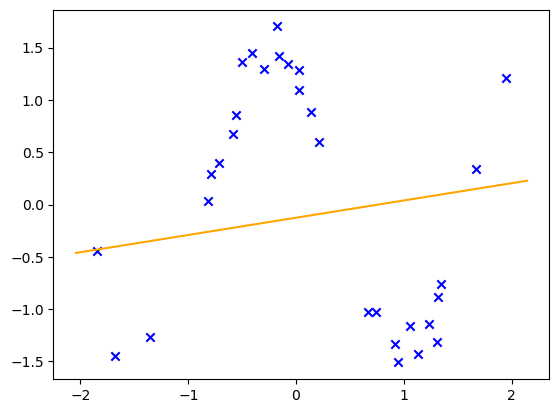

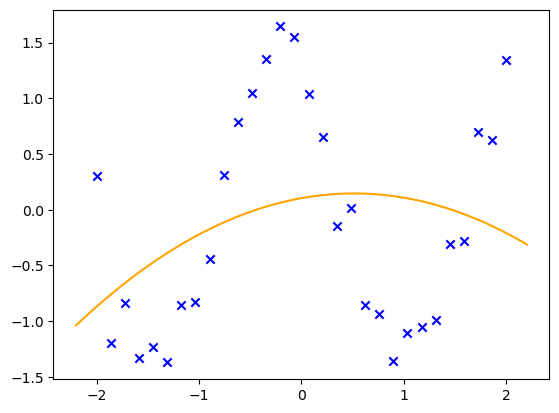

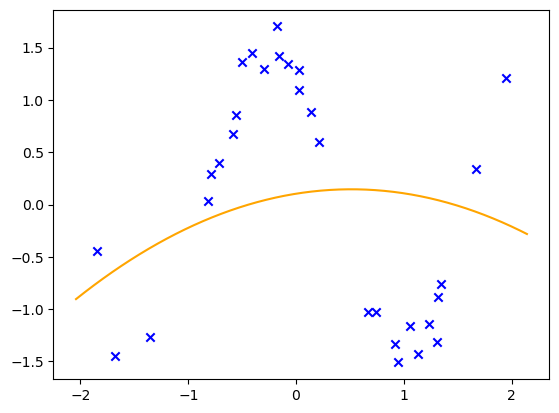

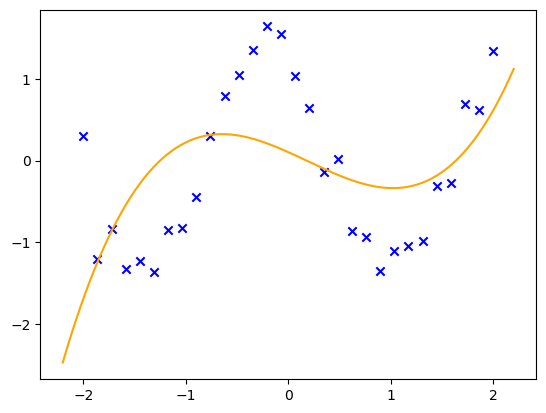

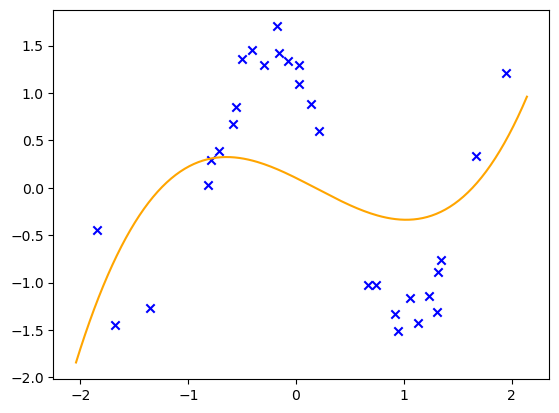

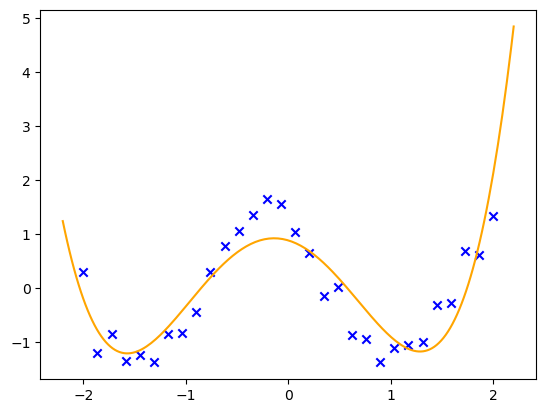

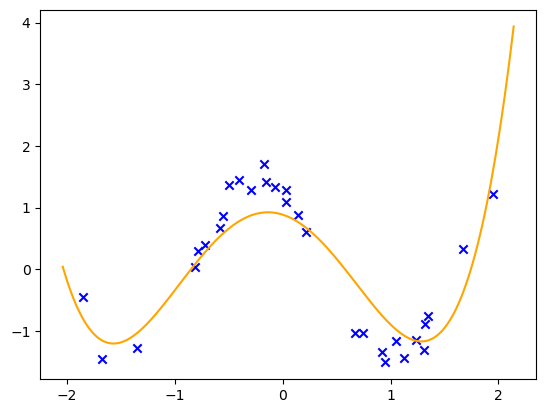

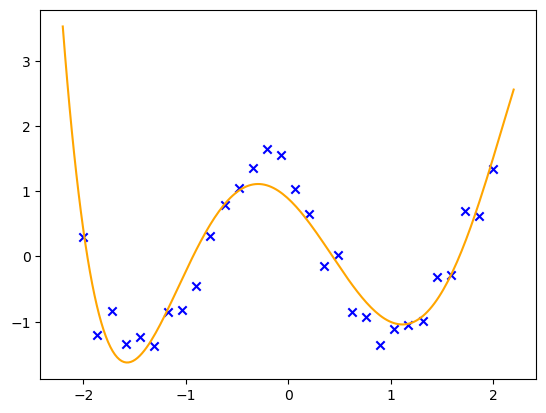

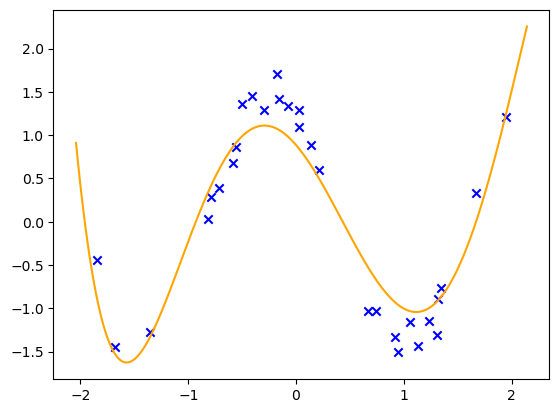

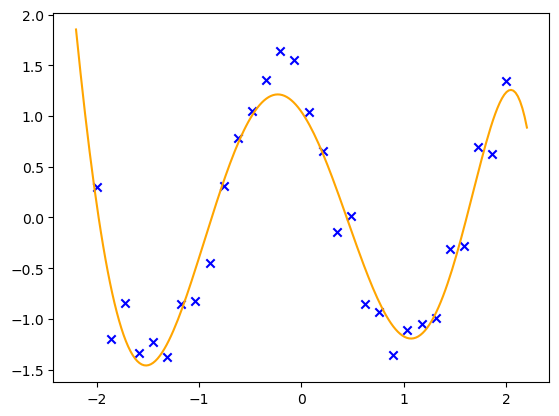

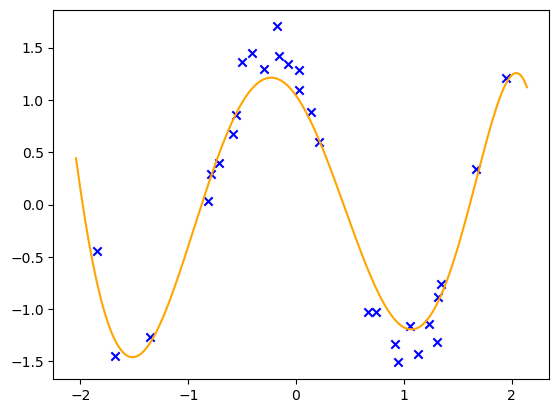

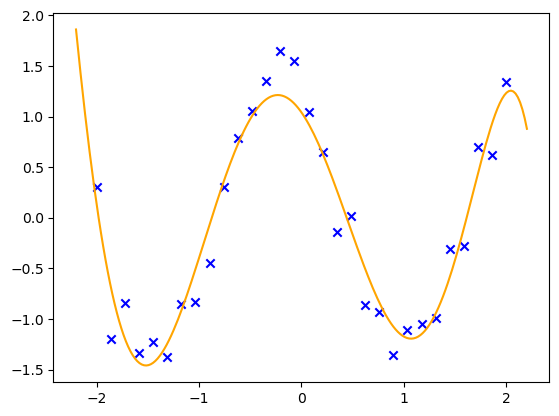

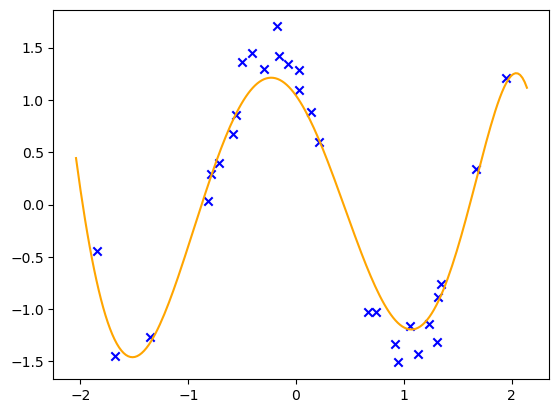

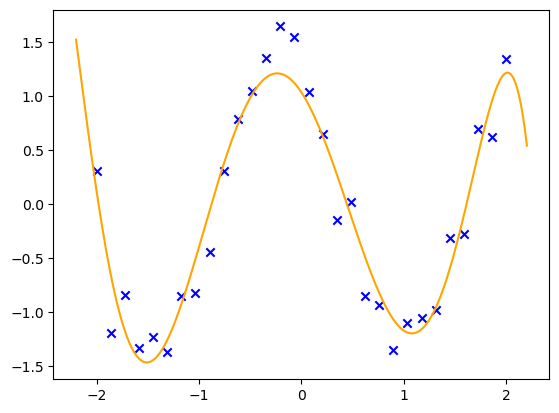

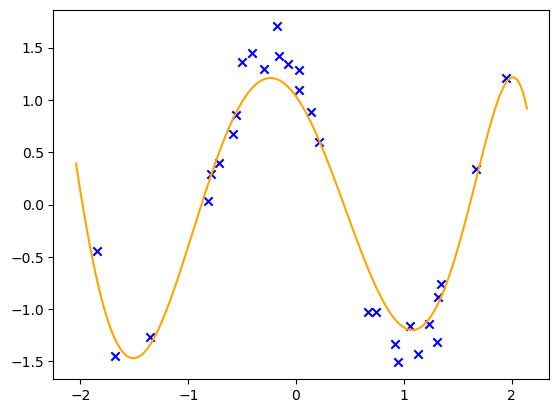

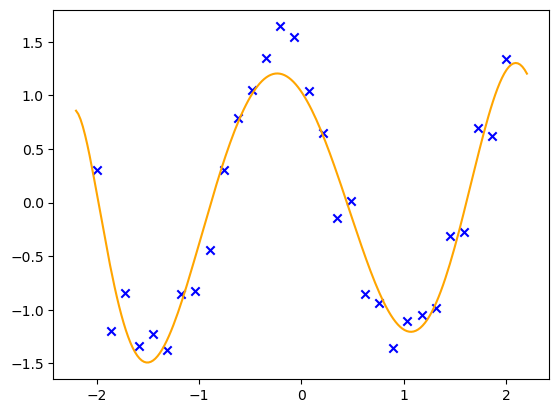

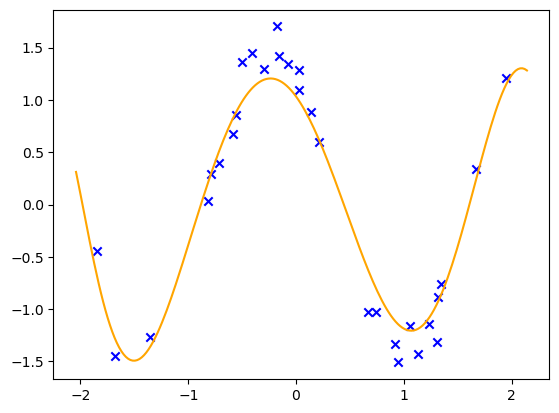

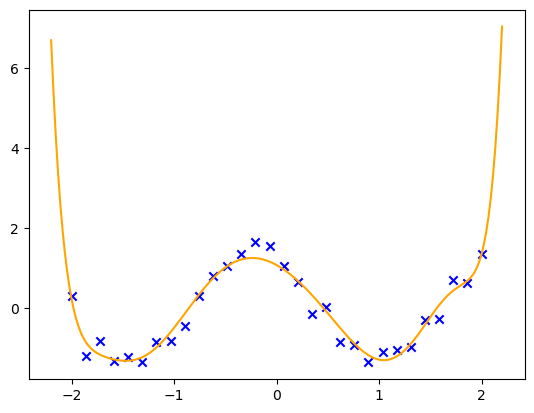

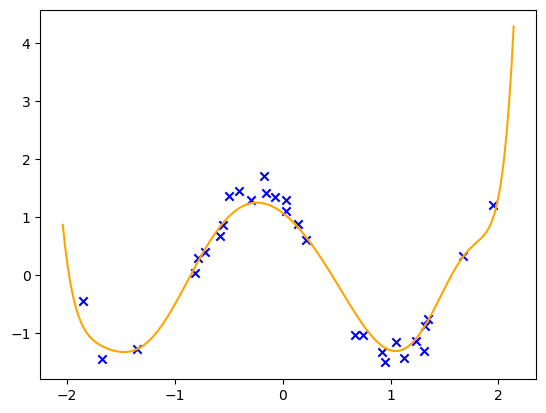

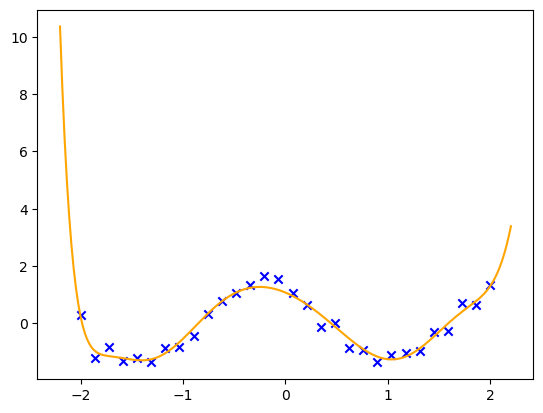

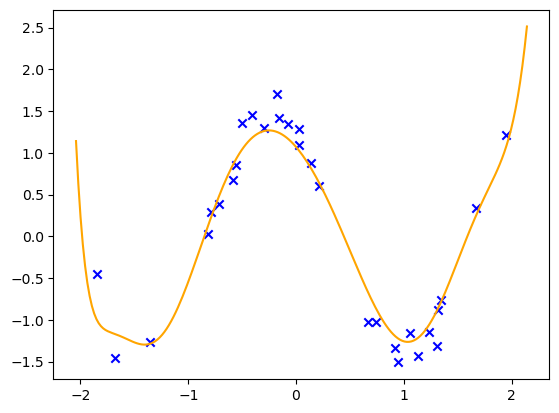

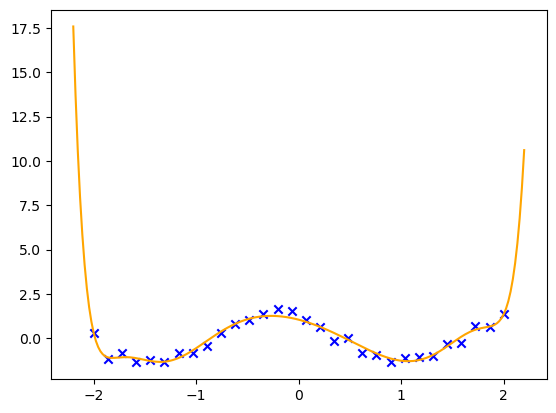

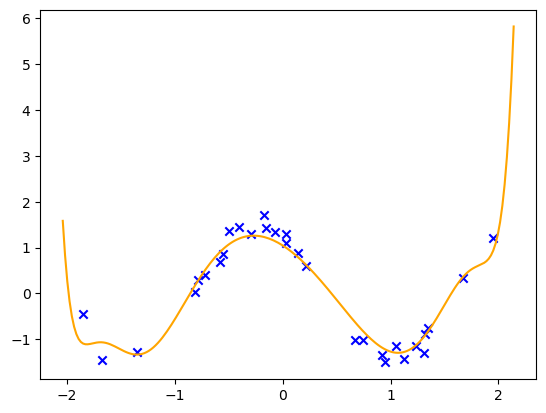

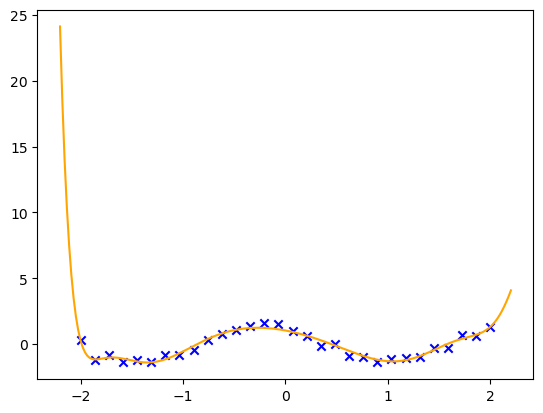

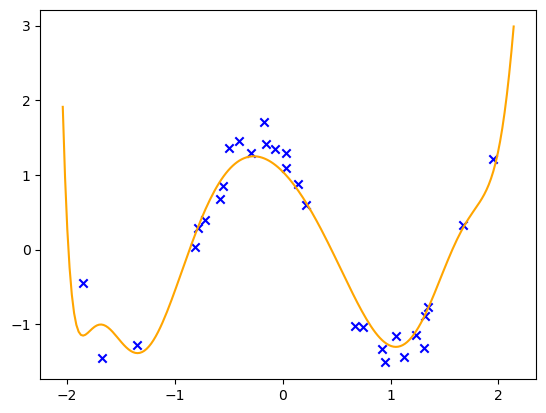

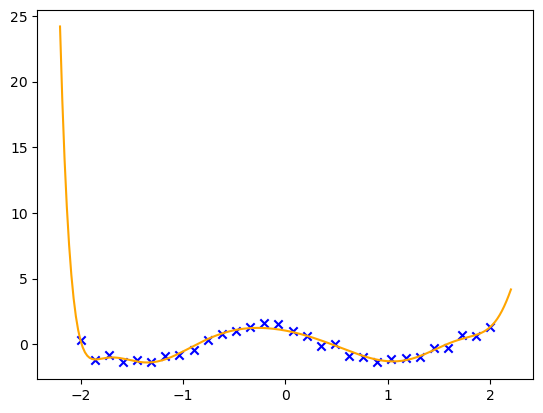

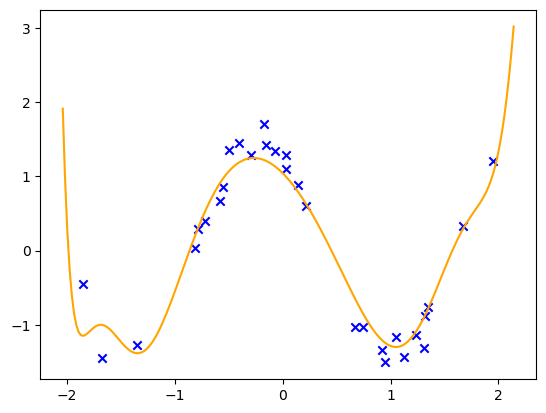

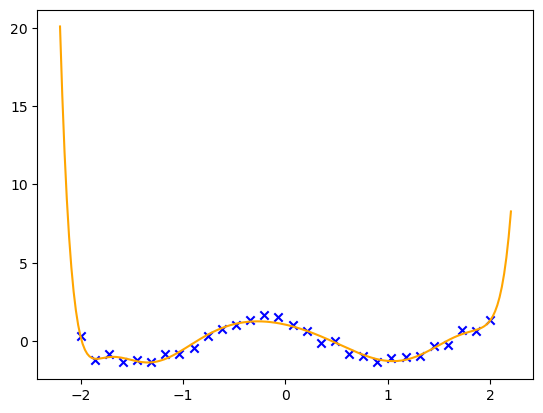

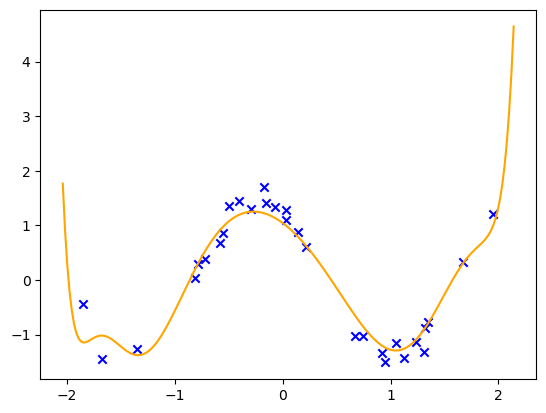

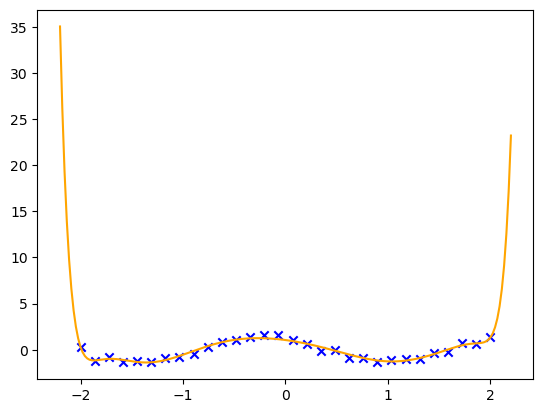

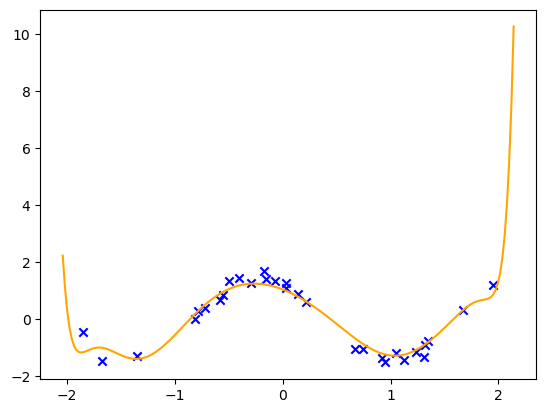

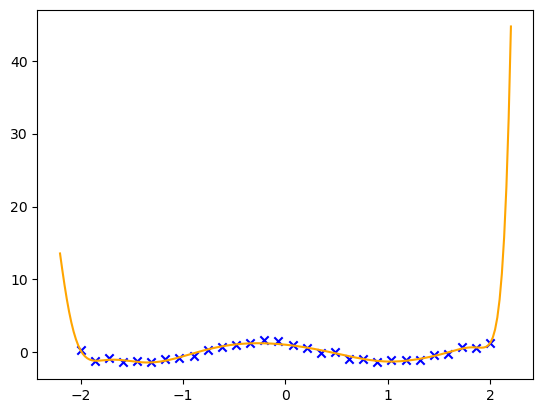

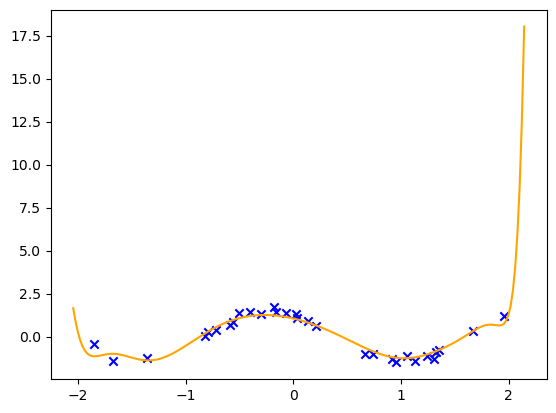

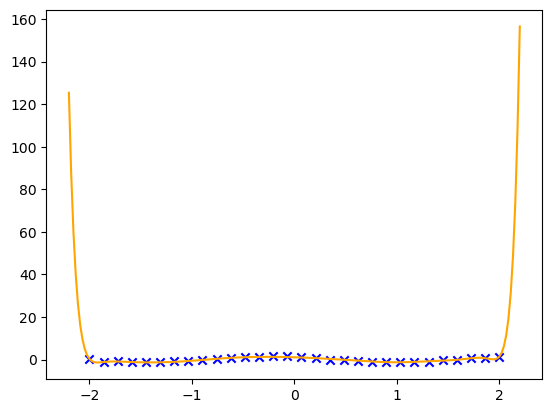

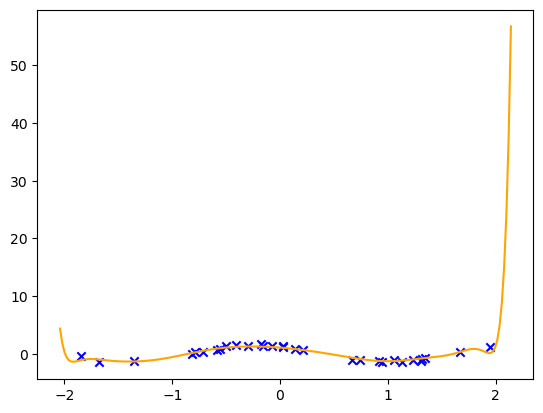

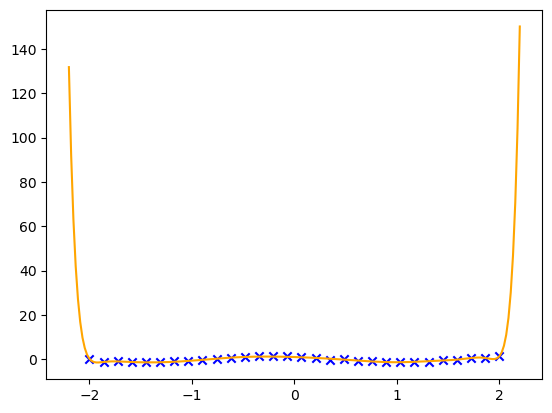

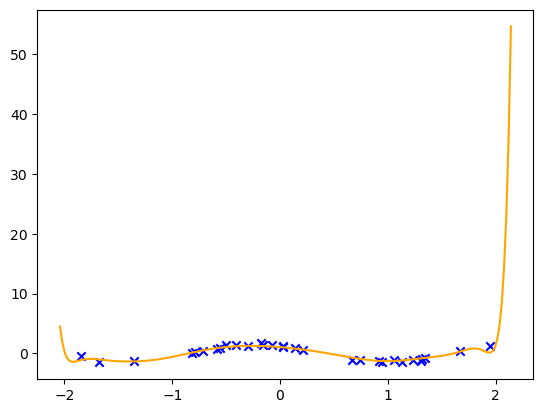

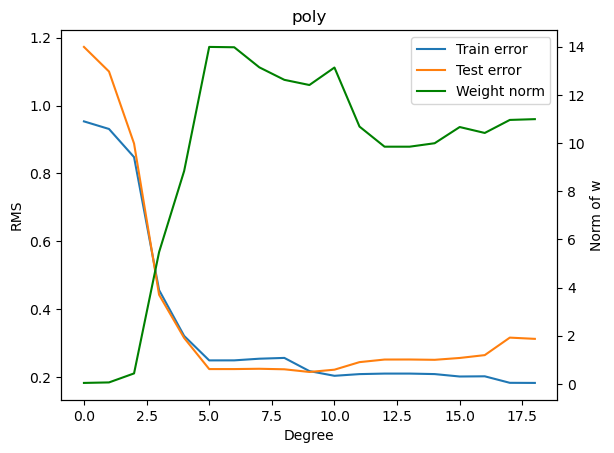

Best test error: 0.21556145521131864


In [67]:
for lam in (0.001, 0.01, 0.1):
    print(f"##### lambda = {lam} #####")
    solver = partial(regularized_least_squares, lam=lam)
    evaluate_basis_function(solver, poly, 20)